In [ ]:
# Part 1: Installation and Setup

# Install necessary libraries

!pip install streamlit pandas numpy scikit-learn matplotlib seaborn joblib pyngrok --quiet
!pip install --upgrade scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 147.0 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import warnings
import sys
# Setup ngrok
from pyngrok import ngrok
import time
import subprocess

# file upload
from google.colab import files
warnings.filterwarnings("ignore")

# Configuration
MODEL_PATH = 'financial_risk_pipeline.joblib'
METRICS_PATH = 'model_metrics_financial.joblib'
DATA_PATH = 'dashboard_data_sample_financial.csv'

# 1. Feature

# Network Traffic Data
UNSW_NB15_COLUMNS = [
    'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes',
    'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
    'dinpkt', 'sjit', 'djit', 'swin', 'dwin', 'tcprtt', 'synack', 'ackdat',
    'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
    'ct_state_ttl', 'ct_dst_ltm', 'ct_srv_dst', 'ct_dst_sport_ltm',
    'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
    'ct_src_ltm', 'ct_slrtm', 'ct_dst_src', 'is_sm_ips_ports', 'ct_srv',
    'ct_dst', 'ct_src', 'ct_spc_dst', 'ct_bps', 'ct_pkts',
    'attack_cat', 'Label'
]

# Financial Transaction Data
FINANCIAL_COLUMNS = [
    'TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate',
    'TransactionType', 'Location', 'DeviceID', 'IPAddress', 'MerchantID',
    'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration',
    'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate',
]

# 2. Data Loading and Preprocessing Functions

def upload_and_process_file(file_type, required_columns):
    """Handles file upload and basic preprocessing."""
    print(f"\n--- UPLOAD DATA: {file_type.upper()} ---")

    # user upload
    if file_type == 'network':
        print("Please upload the UNSW-NB15 file")
        header_setting = None
    elif file_type == 'financial':
        print("Please upload the Financial Transaction file ")
        header_setting = 0
    else:
        print("Invalid file type specified.")
        return None, None

    try:
        uploaded = files.upload()
        if not uploaded:
            print(f"No file uploaded for {file_type}. Cannot continue.")
            return None, None

        csv_name = list(uploaded.keys())[0]

        # Load data
        df = pd.read_csv(csv_name, header=header_setting, low_memory=False)

        # Initialize target_col
        target_col = None


        if file_type == 'network':
            # Network file check
            if len(df.columns) != len(required_columns):
                raise ValueError(f"Network file expected {len(required_columns)} cols, found {len(df.columns)}.")

            df.columns = required_columns
            target_col = 'Label'
            df = df.drop(columns=['attack_cat'], errors='ignore')
            df[target_col] = pd.to_numeric(df[target_col], errors='coerce').fillna(0).astype(int)

        elif file_type == 'financial':

            # FINANCIAL DATA

            # Check for column count consistency
            expected_total_count = len(required_columns)
            expected_feature_count = expected_total_count - 1

            if len(df.columns) != expected_feature_count and len(df.columns) != expected_total_count:
                raise ValueError(f"Financial file expected **{expected_feature_count}** feature cols OR **{expected_total_count}** total cols (with 'IsFraud'), but found {len(df.columns)}.")

            # Feature Engineering  Time Transaction
            df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
            df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'], errors='coerce')
            df['TimeSinceLast'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds() / 3600
            df['TimeSinceLast'] = df['TimeSinceLast'].fillna(df['TimeSinceLast'].median())

            # Create new 'Label' column based on 'LoginAttempts'
            target_col = 'Label'
            df[target_col] = np.where(df['LoginAttempts'] <3, 0, 1).astype(int)
            print("INFO: New 'Label' column created: 0 (Normal) if LoginAttempts < 3, else 1 (Attack).")

            # 4. Drop columns
            df = df.drop(columns=['TransactionID', 'AccountID', 'DeviceID', 'IPAddress', 'MerchantID',
                                 'TransactionDate', 'PreviousTransactionDate'], errors='ignore')

        print(f"Successfully loaded '{csv_name}' for {file_type} with shape: {df.shape}")

        # General cleaning for categorical features
        nominal_cols = df.select_dtypes(include='object').columns.tolist()
        for col in nominal_cols:
            df[col] = df[col].fillna('Unknown')

        return df, target_col

    except Exception as e:
        print(f"\nCRITICAL ERROR during {file_type} data loading: {e}")
        return None, None

# 3. Data Loading and Merging

# Upload and process Network data
network_result = upload_and_process_file('network', UNSW_NB15_COLUMNS)
if network_result is not None:
    network_df, network_target = network_result
else:
    print("Network data is missing.")
    sys.exit(1)

# Upload and process Financial data
financial_result = upload_and_process_file('financial', FINANCIAL_COLUMNS)
if financial_result is not None:
    financial_df, financial_target = financial_result
else:
    print("Financial data is missing. ")
    sys.exit(1)

# MERGE DATA
try:
    merged_df = pd.merge(
        network_df.reset_index(),
        financial_df.reset_index(),
        on='index',
        how='inner',
        suffixes=('_net', '_fin')
    ).set_index('index')

    merged_df = merged_df.rename(columns={'Label_net': 'Label'}).drop(columns=['Label_fin'], errors='ignore')

    print(f"Merge successful. Merged DataFrame shape (Inner Join): {merged_df.shape}")

except Exception as e:
    print(f"CRITICAL ERROR during Inner Join: {e}")
    print("Inner Join often fails if indexes do not align precisely.")
    sys.exit(1)

print(f"\nMerged Data successfully created!")
print(f"Final Merged DataFrame shape: {merged_df.shape}")


--- UPLOAD DATA: NETWORK ---
Please upload the UNSW-NB15 file


Saving UNSW-NB15_1.csv to UNSW-NB15_1 (4).csv
Successfully loaded 'UNSW-NB15_1 (4).csv' for network with shape: (2962, 48)

--- UPLOAD DATA: FINANCIAL ---
Please upload the Financial Transaction file 


Saving bank_transactions_data_2.csv to bank_transactions_data_2 (4).csv
INFO: New 'Label' column created: 0 (Normal) if LoginAttempts < 3, else 1 (Attack).
Successfully loaded 'bank_transactions_data_2 (4).csv' for financial with shape: (2512, 12)
Merge successful. Merged DataFrame shape (Inner Join): (2512, 59)

Merged Data successfully created!
Final Merged DataFrame shape: (2512, 59)


In [ ]:
merged_df

dur  proto        service  state spkts dpkts     sbytes  dbytes  \
index                                                                           
0      59.166.0.0   1390  149.171.126.6     53   udp   CON   0.001055     132   
1      59.166.0.0  33661  149.171.126.9   1024   udp   CON   0.036133     528   
2      59.166.0.6   1464  149.171.126.7     53   udp   CON   0.001119     146   
3      59.166.0.5   3593  149.171.126.5     53   udp   CON   0.001209     132   
4      59.166.0.3  49664  149.171.126.0     53   udp   CON   0.001169     146   
...           ...    ...            ...    ...   ...   ...        ...     ...   
2507   59.166.0.4  22105  149.171.126.5  58482   tcp   FIN   0.053993    3806   
2508   59.166.0.7  15392  149.171.126.4  41432   tcp   FIN   0.029047    3806   
2509   59.166.0.8  62897  149.171.126.4     25   tcp   FIN   0.439847   37230   
2510   59.166.0.3  61046  149.171.126.3  23183   tcp   FIN   1.454488    8928   
2511   59.166.0.4  63195  149.171.126.0     21   tcp   FIN  12.994872    2934   

        rate  sttl  ...  TransactionType          Location      IP Address  \
index               ...                                                      
0        164    31  ...            Debit         San Diego  162.198.218.92   
1        304    31  ...            Debit           Houston     13.149.61.4   
2        178    31  ...            Debit              Mesa  215.97.143.157   
3        164    31  ...            Debit           Raleigh  200.13.225.150   
4        178    31  ...           Credit           Atlanta    65.164.3.100   
...      ...   ...  ...              ...               ...             ...   
2507   51808    31  ...           Credit  Colorado Springs    21.157.41.17   
2508   51808    31  ...            Debit            Tucson  49.174.157.140   
2509    3380    31  ...            Debit         San Diego     58.1.27.124   
2510     320    31  ...            Debit            Denver   21.190.11.223   
2511    3740    31  ...           Credit      Jacksonville   59.127.135.25   

      Channel  CustomerAge  CustomerOccupation  TransactionDuration  \
index                                                                 
0         ATM           70              Doctor                   81   
1         ATM           68              Doctor                  141   
2      Online           19             Student                   56   
3      Online           26             Student                   25   
4      Online           26             Student                  198   
...       ...          ...                 ...                  ...   
2507   Branch           33              Doctor                  109   
2508   Branch           48              Doctor                  177   
2509   Branch           56             Retired                  146   
2510   Online           23             Student                   19   
2511   Online           24             Student                   93   

       LoginAttempts  AccountBalance  TimeSinceLast  
index                                                
0                  1         5112.21  -13743.648333  
1                  1        13758.91  -11895.421111  
2                  1         1122.35  -11581.848889  
3                  1         8569.06  -13167.615278  
4                  1         7429.40   -9230.254167  
...              ...             ...            ...  
2507               1        12690.79  -13383.031389  
2508               1          254.75  -14222.581667  
2509               1         3382.91  -10574.996944  
2510               1         1776.91  -14847.793333  
2511               1          131.25  -15087.773889  

[2512 rows x 59 columns]

In [ ]:
merged_df.describe()

proto       sbytes         dbytes          rate         sttl  \
count   2512.000000  2512.000000    2512.000000  2.512000e+03  2512.000000   
mean   32190.344347     4.102167    3201.138933  2.211638e+04    35.095939   
std    19136.513780     7.929765    7082.238800  1.283262e+05    29.615886   
min        0.000000     0.000000      46.000000  0.000000e+00     0.000000   
25%    15611.750000     0.033137     568.000000  8.240000e+02    31.000000   
50%    31846.000000     0.963918    1540.000000  1.644000e+03    31.000000   
75%    48983.250000     3.763024    2302.000000  8.824000e+03    31.000000   
max    65534.000000    50.004387  115727.000000  1.641360e+06   254.000000   

              dttl        sload        dload         dloss        sinpkt  ...  \
count  2512.000000  2512.000000  2512.000000  2.512000e+03  2.512000e+03  ...   
mean     34.231290     4.904459    11.469347  1.582563e+06  6.915318e+05  ...   
std      35.400145     6.378824    45.537314  3.762343e+07  2.065157e+06  ...   
min       0.000000     0.000000     0.000000  0.000000e+00  0.000000e+00  ...   
25%      29.000000     1.000000     2.000000  3.694056e+03  4.913987e+03  ...   
50%      29.000000     4.000000     4.000000  1.390930e+04  2.879812e+04  ...   
75%      29.000000     5.000000     8.000000  4.685981e+05  5.232792e+05  ...   
max     252.000000    55.000000   583.000000  1.805333e+09  1.648563e+07  ...   

        ct_spc_dst       ct_bps      ct_pkts        Label  TransactionAmount  \
count  2512.000000  2512.000000  2512.000000  2512.000000        2512.000000   
mean      3.529459     1.021497     2.400478     0.031449         297.593778   
std       4.114056     0.181633     1.956020     0.174563         291.946243   
min       1.000000     1.000000     1.000000     0.000000           0.260000   
25%       1.000000     1.000000     1.000000     0.000000          81.885000   
50%       1.000000     1.000000     1.000000     0.000000         211.140000   
75%       5.000000     1.000000     3.000000     0.000000         414.527500   
max      19.000000     4.000000    11.000000     1.000000        1919.110000   

       CustomerAge  TransactionDuration  LoginAttempts  AccountBalance  \
count  2512.000000          2512.000000    2512.000000     2512.000000   
mean     44.673965           119.643312       1.124602     5114.302966   
std      17.792198            69.963757       0.602662     3900.942499   
min      18.000000            10.000000       1.000000      101.250000   
25%      27.000000            63.000000       1.000000     1504.370000   
50%      45.000000           112.500000       1.000000     4735.510000   
75%      59.000000           161.000000       1.000000     7678.820000   
max      80.000000           300.000000       5.000000    14977.990000   

       TimeSinceLast  
count    2512.000000  
mean   -11699.619831  
std      2553.112410  
min    -16120.185556  
25%    -13935.794653  
50%    -11654.350833  
75%     -9469.433750  
max     -7381.747500  

[8 rows x 48 columns]

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2512 entries, 0 to 2511
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dur                  2512 non-null   object 
 1   proto                2512 non-null   int64  
 2   service              2512 non-null   object 
 3   state                2512 non-null   object 
 4   spkts                2512 non-null   object 
 5   dpkts                2512 non-null   object 
 6   sbytes               2512 non-null   float64
 7   dbytes               2512 non-null   int64  
 8   rate                 2512 non-null   int64  
 9   sttl                 2512 non-null   int64  
 10  dttl                 2512 non-null   int64  
 11  sload                2512 non-null   int64  
 12  dload                2512 non-null   int64  
 13  sloss                2512 non-null   object 
 14  dloss                2512 non-null   float64
 15  sinpkt               2512 non-null   float6

Categorical (<= 15 unique): ['spkts', 'dpkts', 'sloss', 'TransactionType', 'Channel', 'CustomerOccupation']
Numerical: ['proto', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_srv_dst', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_slrtm', 'ct_dst_src', 'is_sm_ips_ports', 'ct_srv', 'ct_dst', 'ct_src', 'ct_spc_dst', 'ct_bps', 'ct_pkts', 'Label', 'TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'TimeSinceLast']


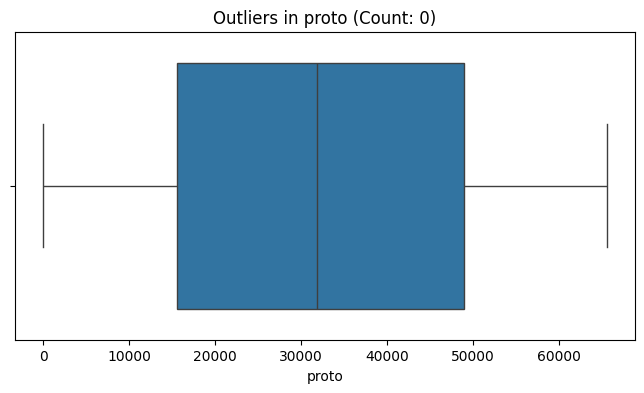

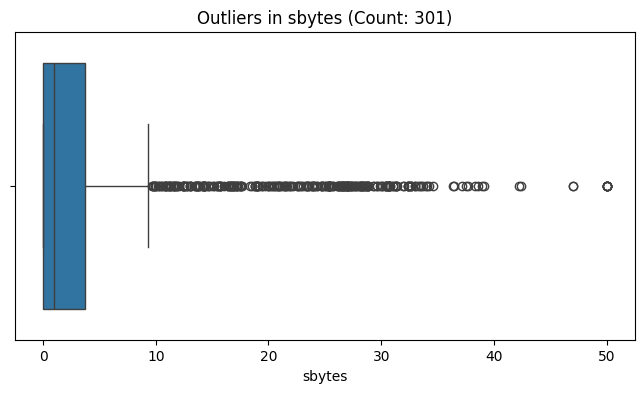

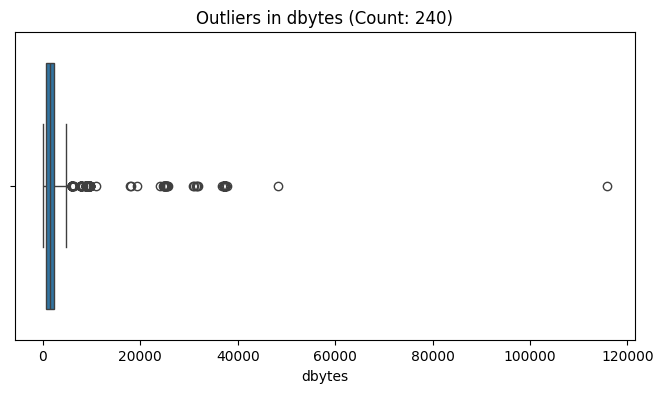

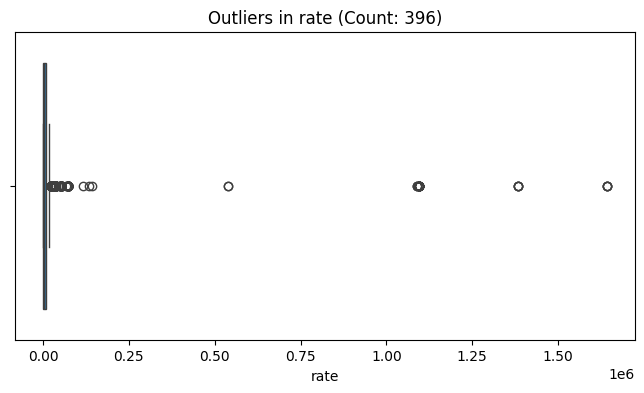

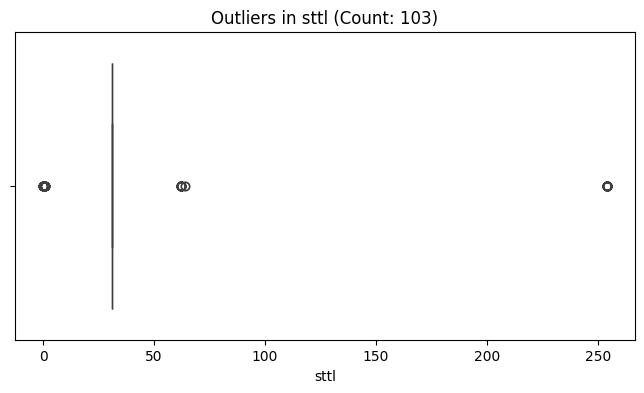

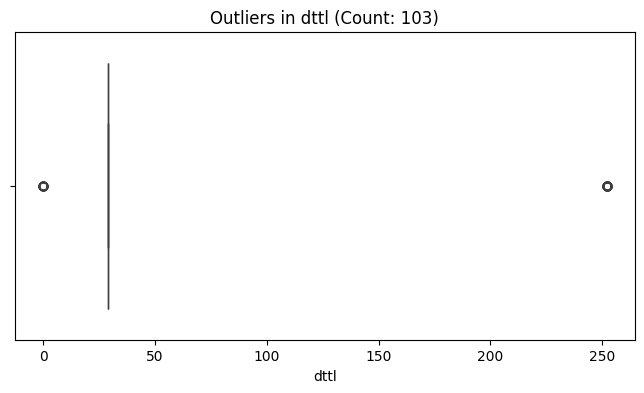

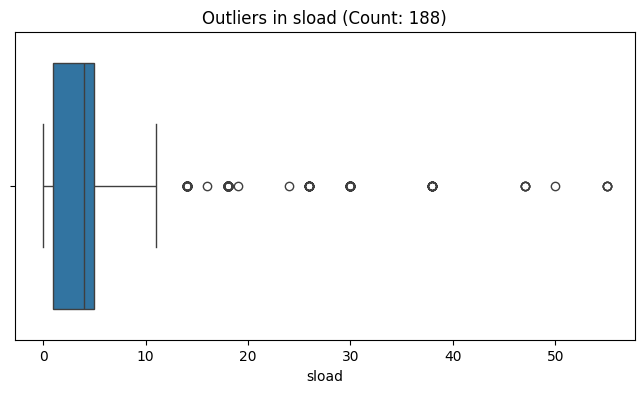

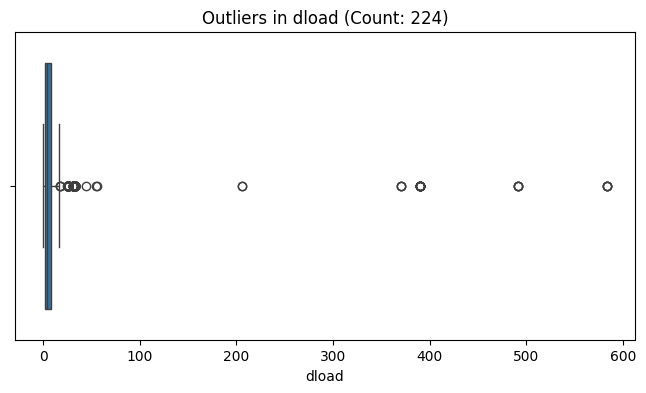

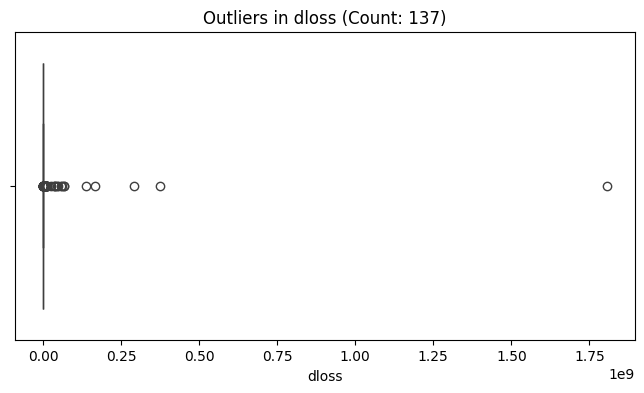

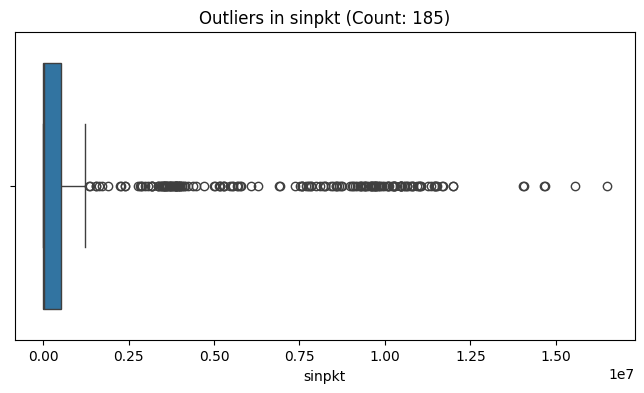

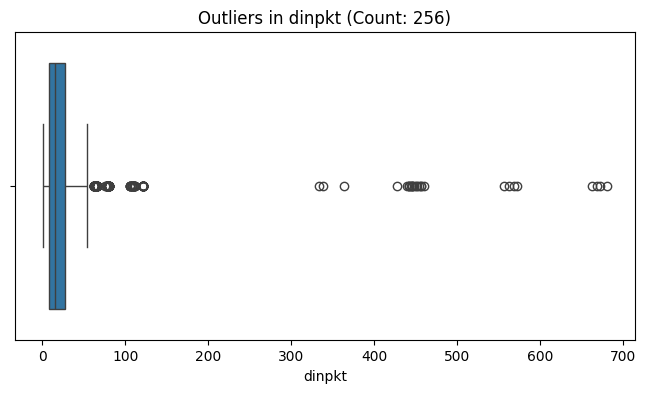

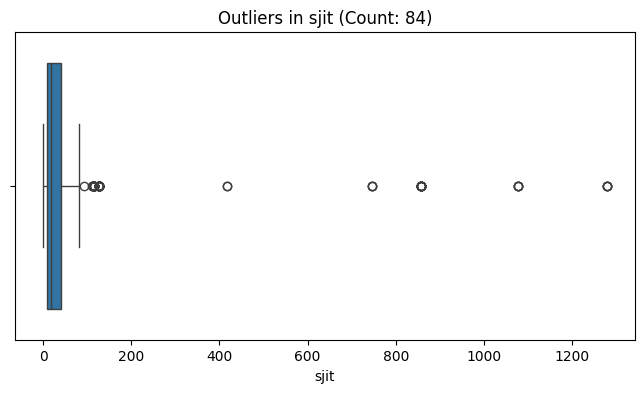

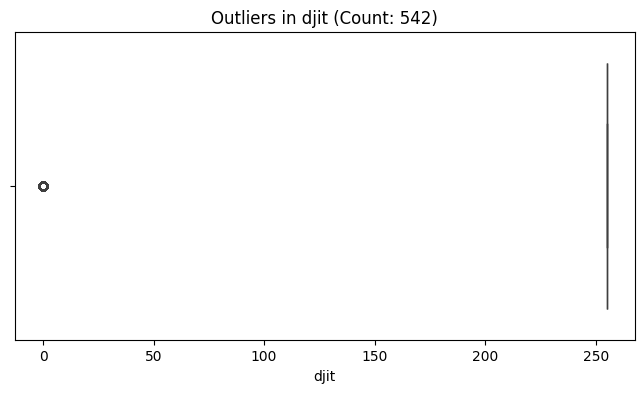

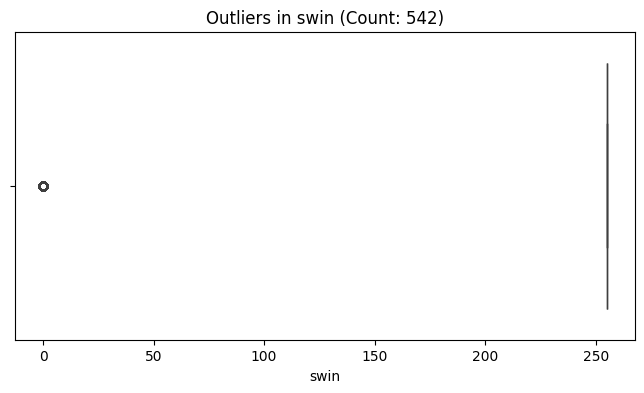

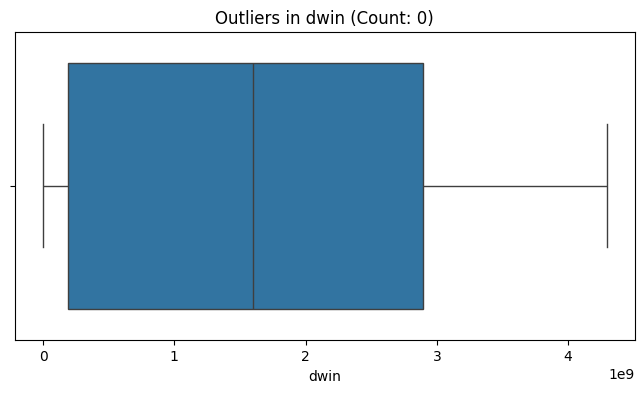

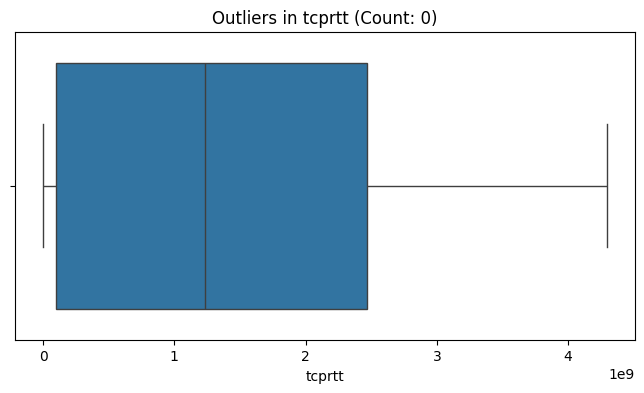

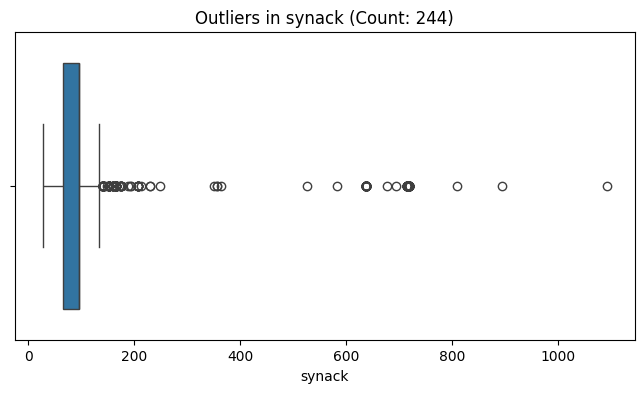

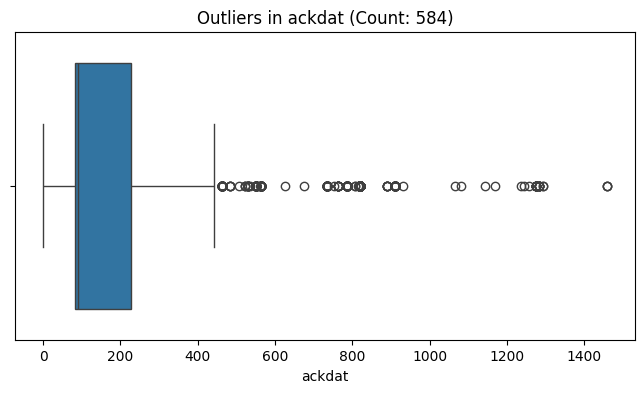

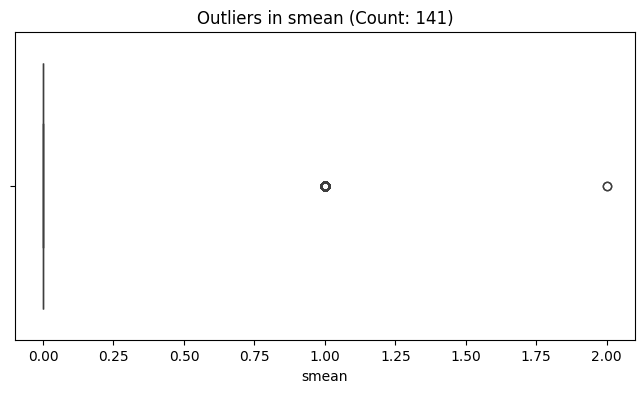

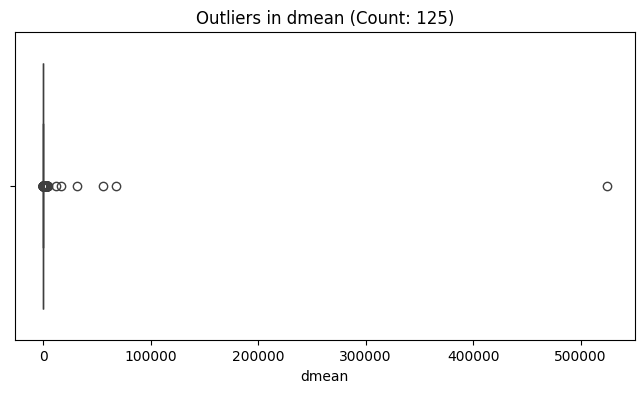

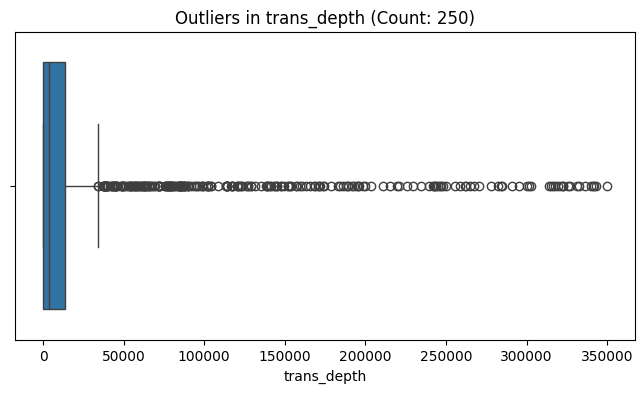

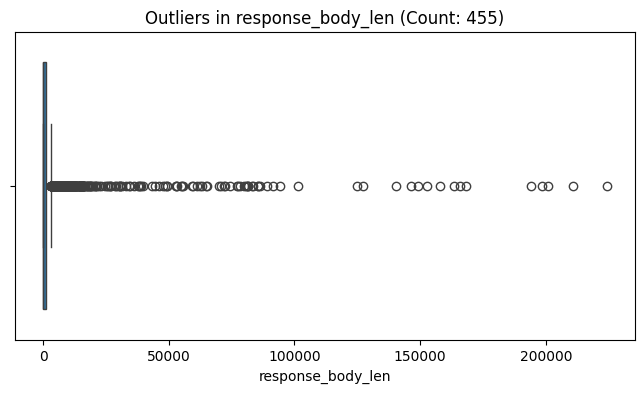

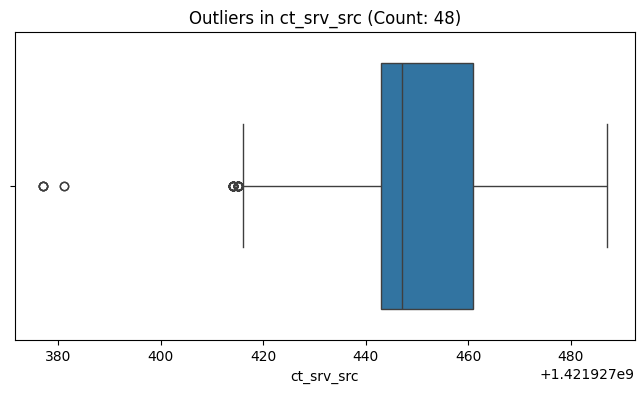

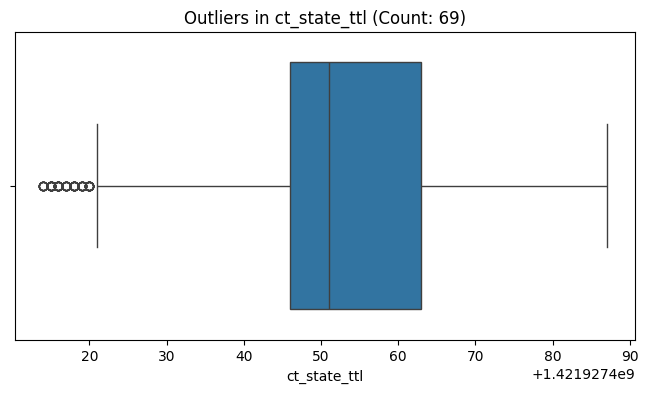

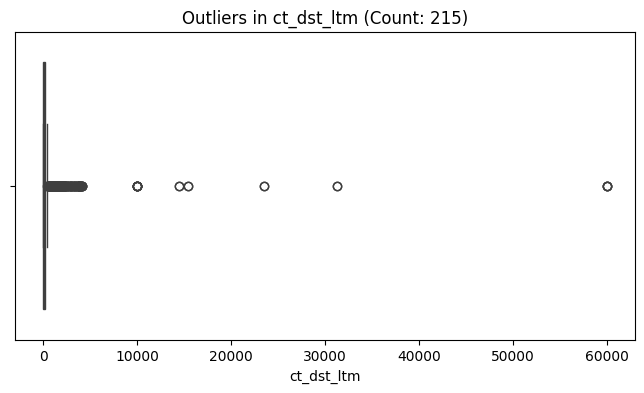

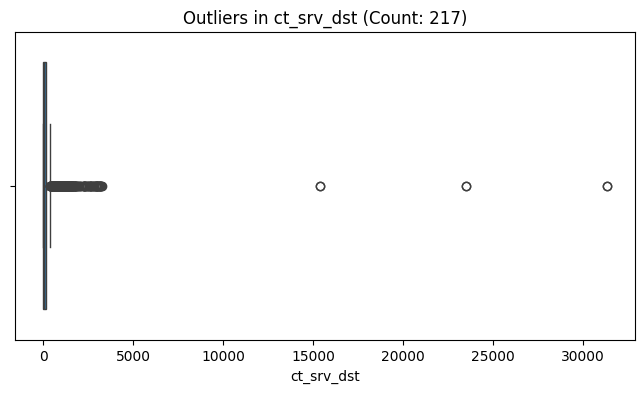

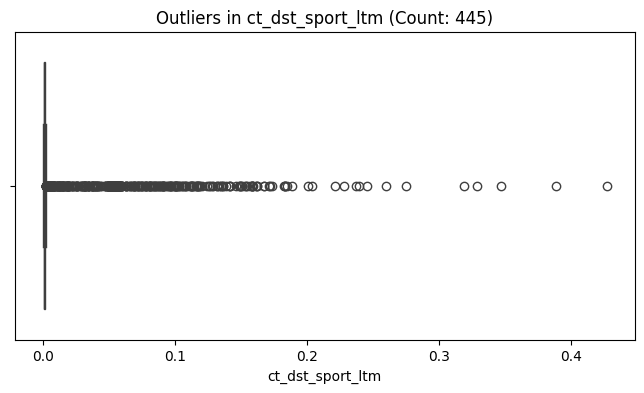

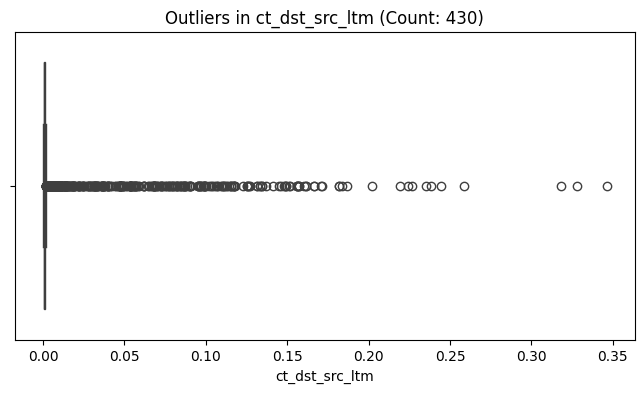

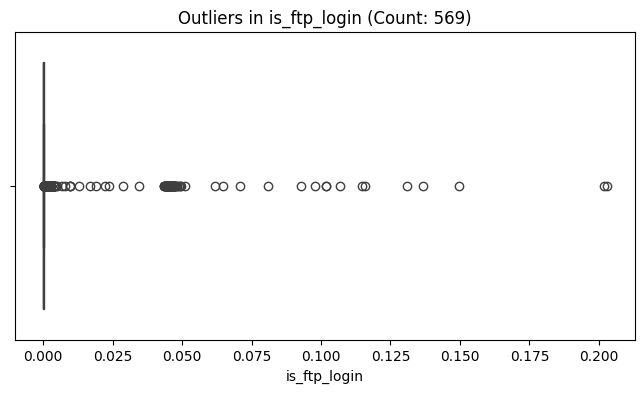

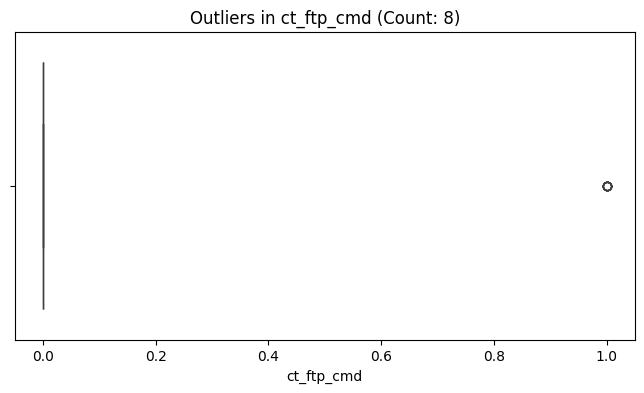

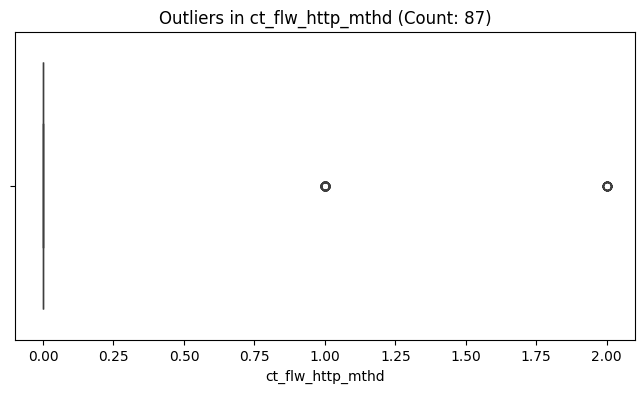

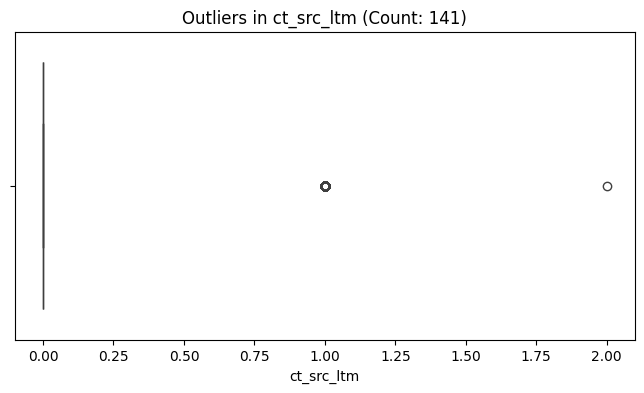

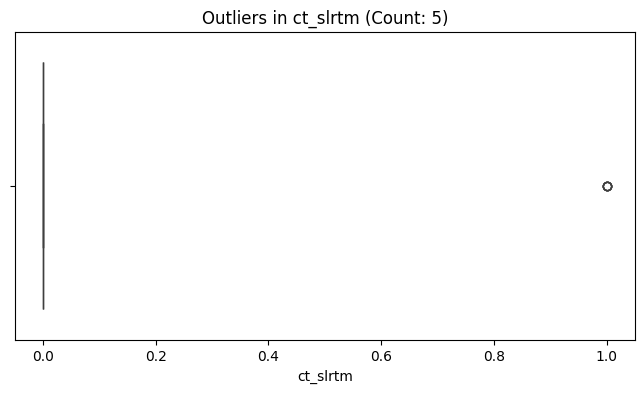

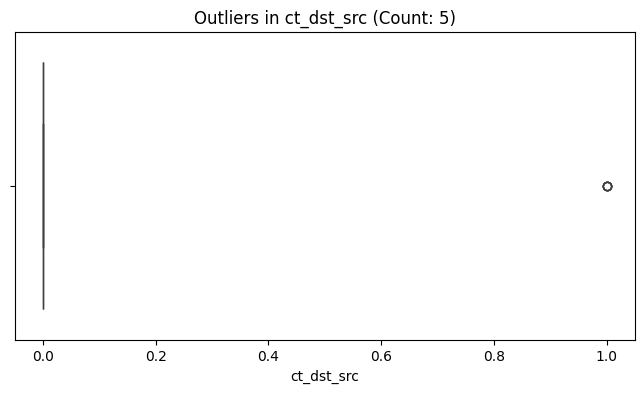

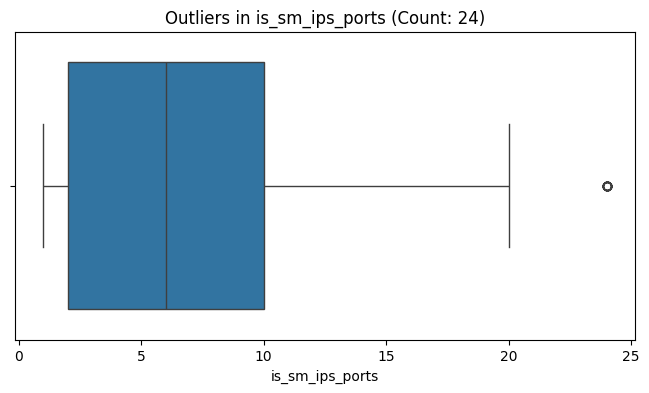

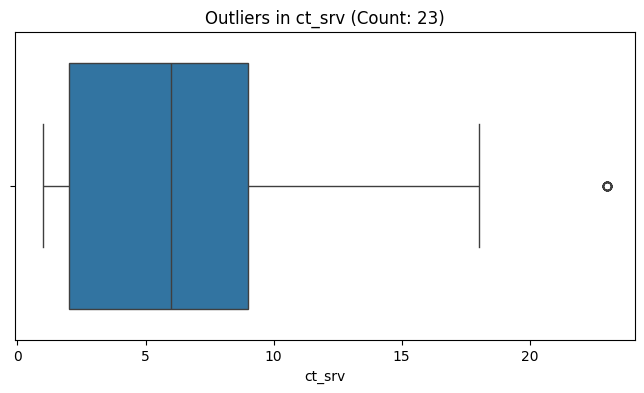

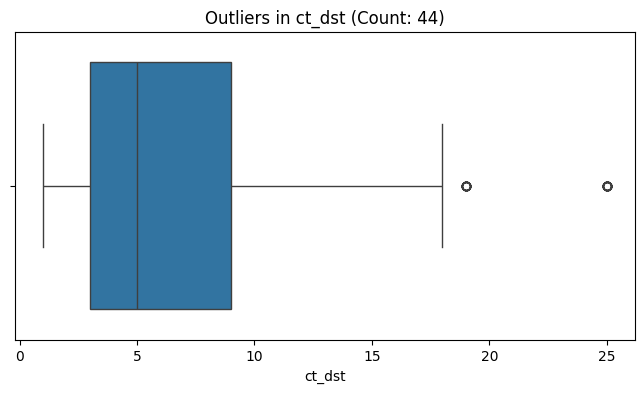

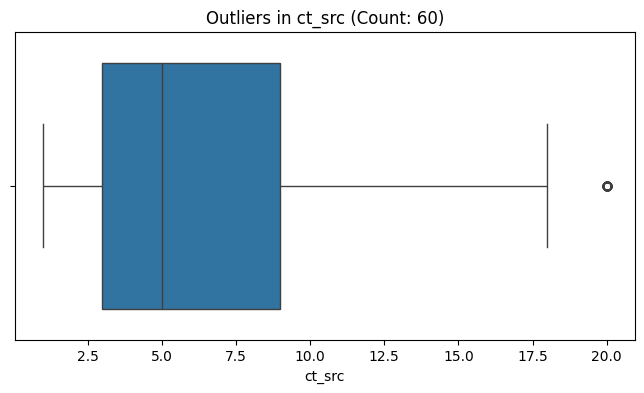

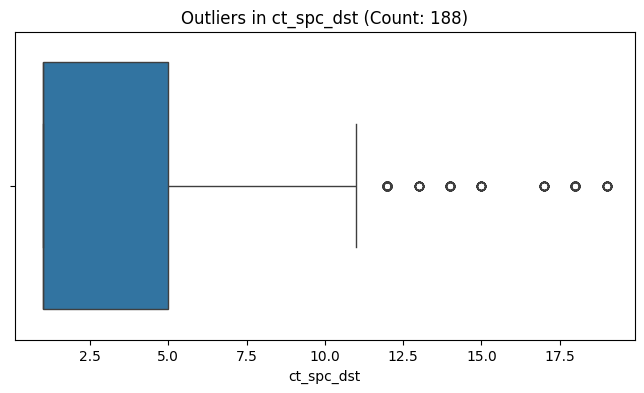

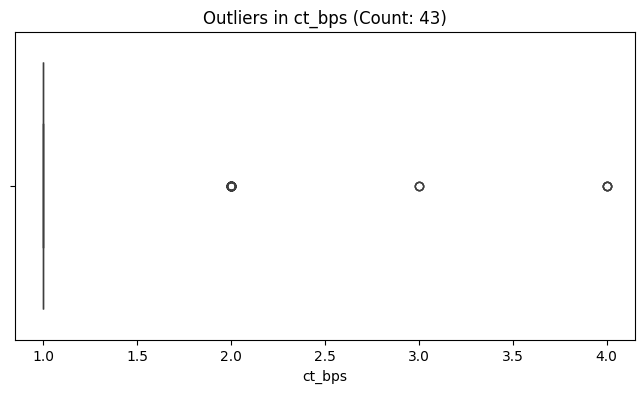

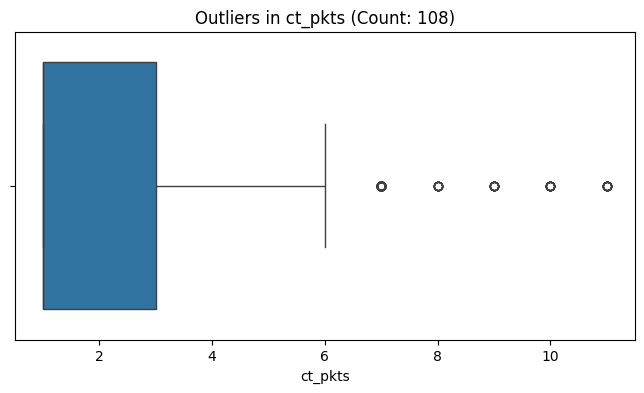

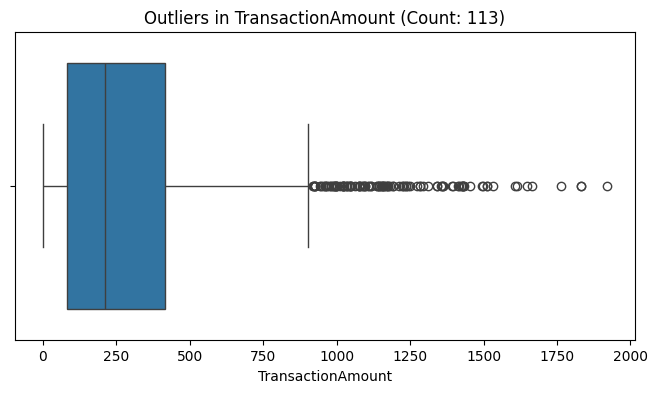

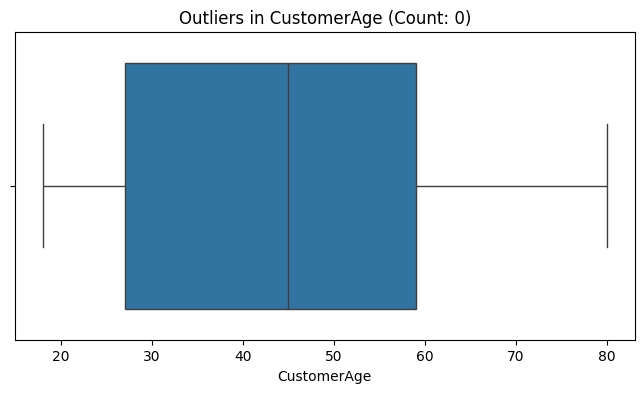

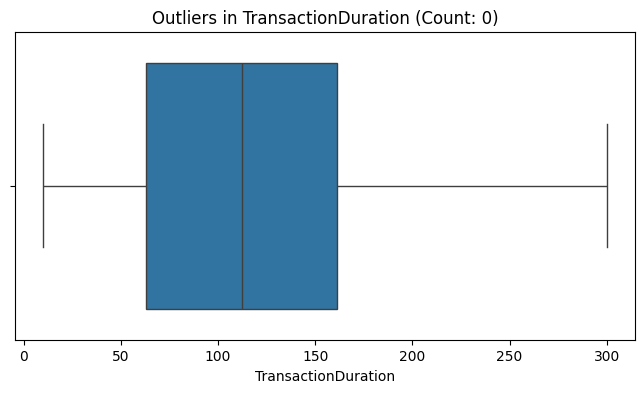

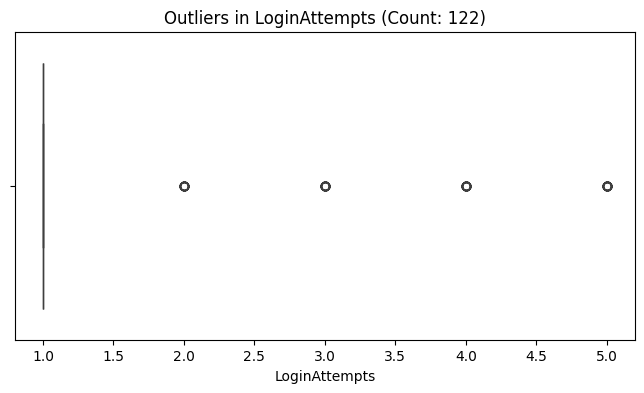

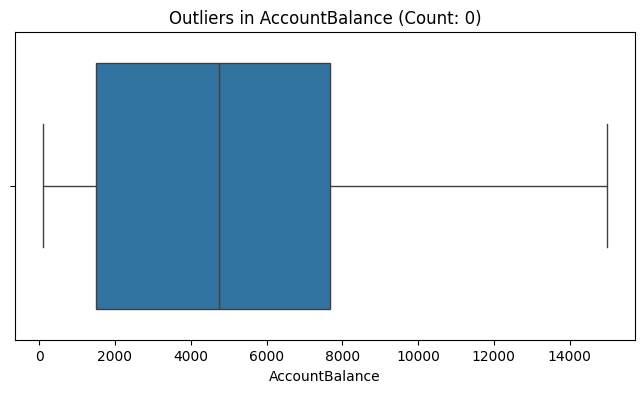

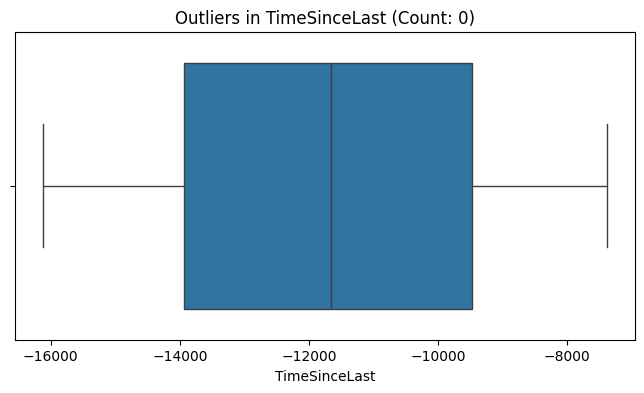

In [ ]:
import plotly.express as px
merged_df2 = merged_df.copy()
cat_cols = [col for col in merged_df.columns if merged_df[col].dtype == 'object' and merged_df[col].nunique() <= 15]
num_cols = [col for col in merged_df.columns if merged_df[col].dtype != 'object']

print("Categorical (<= 15 unique):", cat_cols)
print("Numerical:", num_cols)

# Outlier Detection (IQR method)

for col in num_cols:
    if col != "Label":
        Q1 = merged_df[col].quantile(0.25)
        Q3 = merged_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        merged_df2[col] = np.clip(merged_df[col], lower, upper)
        outliers = merged_df[(merged_df[col] < Q1 - 1.5*IQR) | (merged_df[col] > Q3 + 1.5*IQR)]

        plt.figure(figsize=(8, 4))
        sns.boxplot(x=merged_df[col])
        plt.title(f"Outliers in {col} (Count: {len(outliers)})")
        plt.show()




In [ ]:
merged_df2.describe()

proto       sbytes       dbytes          rate    sttl    dttl  \
count   2512.000000  2512.000000  2512.000000   2512.000000  2512.0  2512.0   
mean   32190.344347     2.440096  1819.044586   5617.476115    31.0    29.0   
std    19136.513780     3.135942  1461.483692   7559.579587     0.0     0.0   
min        0.000000     0.000000    46.000000      0.000000    31.0    29.0   
25%    15611.750000     0.033137   568.000000    824.000000    31.0    29.0   
50%    31846.000000     0.963918  1540.000000   1644.000000    31.0    29.0   
75%    48983.250000     3.763024  2302.000000   8824.000000    31.0    29.0   
max    65534.000000     9.357854  4903.000000  20824.000000    31.0    29.0   

             sload        dload         dloss        sinpkt  ...   ct_spc_dst  \
count  2512.000000  2512.000000  2.512000e+03  2.512000e+03  ...  2512.000000   
mean      3.975717     5.859475  2.067232e+05  2.592630e+05  ...     3.236465   
std       3.169920     5.781616  3.343707e+05  3.923547e+05  ...     3.284683   
min       0.000000     0.000000  0.000000e+00  0.000000e+00  ...     1.000000   
25%       1.000000     2.000000  3.694056e+03  4.913987e+03  ...     1.000000   
50%       4.000000     4.000000  1.390930e+04  2.879812e+04  ...     1.000000   
75%       5.000000     8.000000  4.685981e+05  5.232792e+05  ...     5.000000   
max      11.000000    17.000000  1.165954e+06  1.300827e+06  ...    11.000000   

       ct_bps      ct_pkts        Label  TransactionAmount  CustomerAge  \
count  2512.0  2512.000000  2512.000000        2512.000000  2512.000000   
mean      1.0     2.317675     0.031449         284.847250    44.673965   
std       0.0     1.725312     0.174563         252.067285    17.792198   
min       1.0     1.000000     0.000000           0.260000    18.000000   
25%       1.0     1.000000     0.000000          81.885000    27.000000   
50%       1.0     1.000000     0.000000         211.140000    45.000000   
75%       1.0     3.000000     0.000000         414.527500    59.000000   
max       1.0     6.000000     1.000000         913.491250    80.000000   

       TransactionDuration  LoginAttempts  AccountBalance  TimeSinceLast  
count          2512.000000         2512.0     2512.000000    2512.000000  
mean            119.643312            1.0     5114.302966  -11699.619831  
std              69.963757            0.0     3900.942499    2553.112410  
min              10.000000            1.0      101.250000  -16120.185556  
25%              63.000000            1.0     1504.370000  -13935.794653  
50%             112.500000            1.0     4735.510000  -11654.350833  
75%             161.000000            1.0     7678.820000   -9469.433750  
max             300.000000            1.0    14977.990000   -7381.747500  

[8 rows x 48 columns]

In [ ]:
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2512 entries, 0 to 2511
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dur                  2512 non-null   object 
 1   proto                2512 non-null   int64  
 2   service              2512 non-null   object 
 3   state                2512 non-null   object 
 4   spkts                2512 non-null   object 
 5   dpkts                2512 non-null   object 
 6   sbytes               2512 non-null   float64
 7   dbytes               2512 non-null   int64  
 8   rate                 2512 non-null   int64  
 9   sttl                 2512 non-null   int64  
 10  dttl                 2512 non-null   int64  
 11  sload                2512 non-null   int64  
 12  dload                2512 non-null   int64  
 13  sloss                2512 non-null   object 
 14  dloss                2512 non-null   float64
 15  sinpkt               2512 non-null   float6

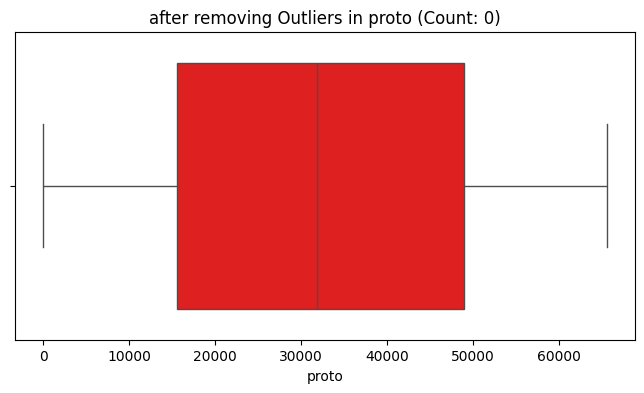

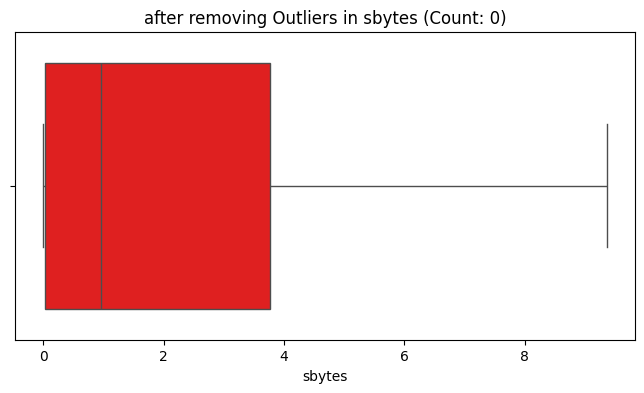

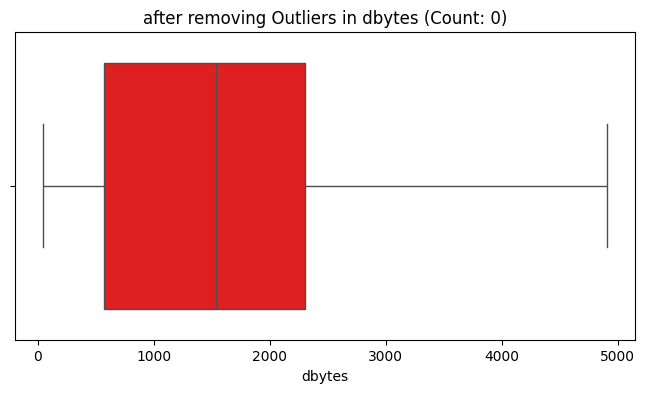

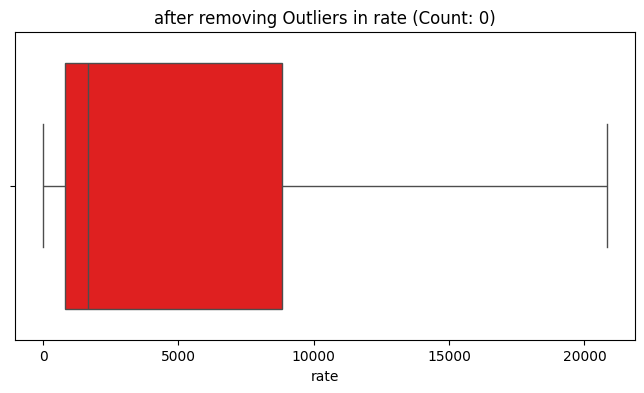

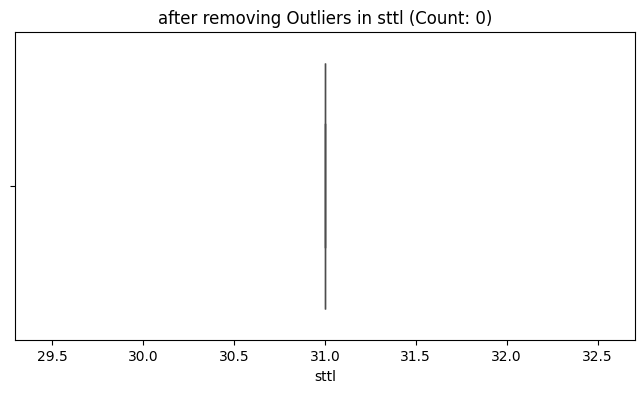

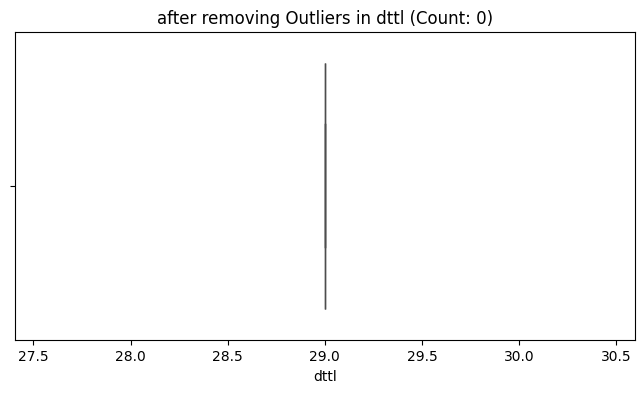

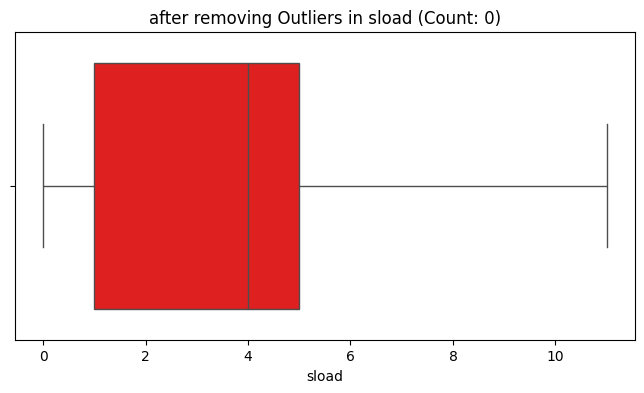

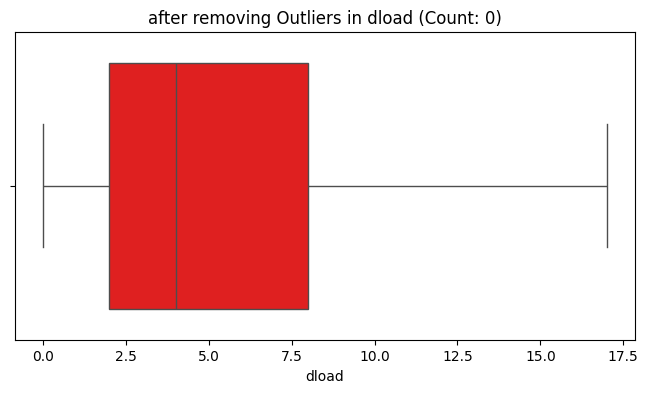

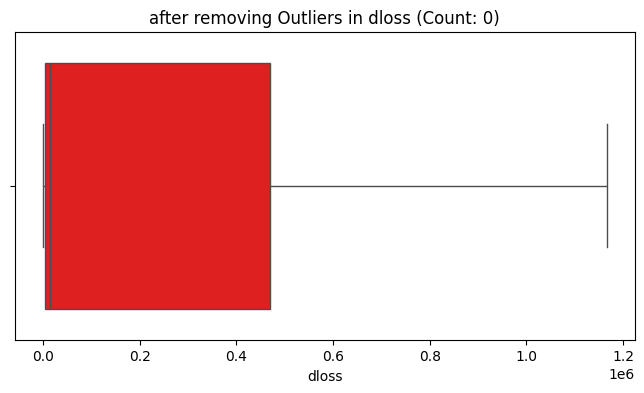

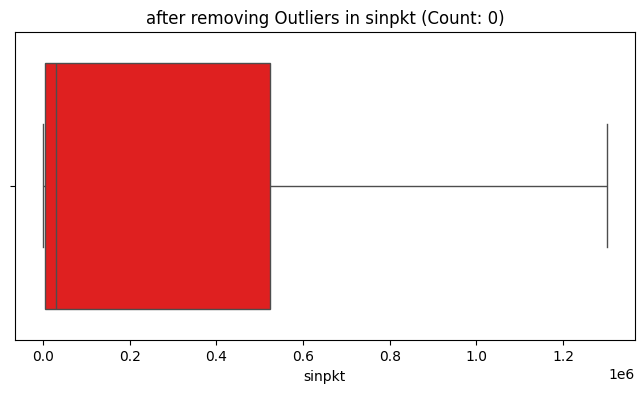

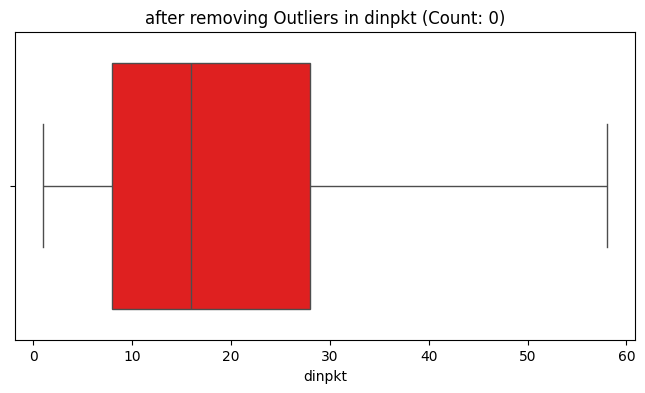

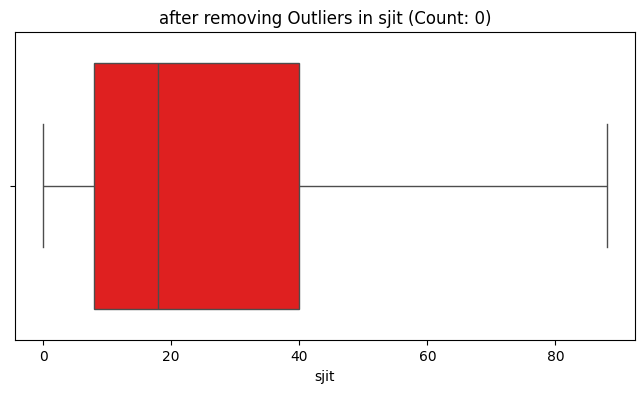

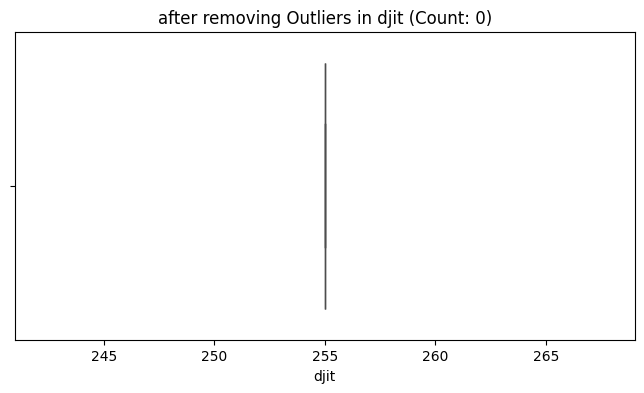

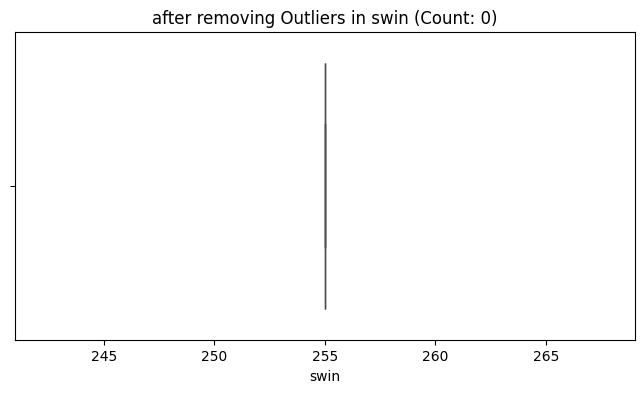

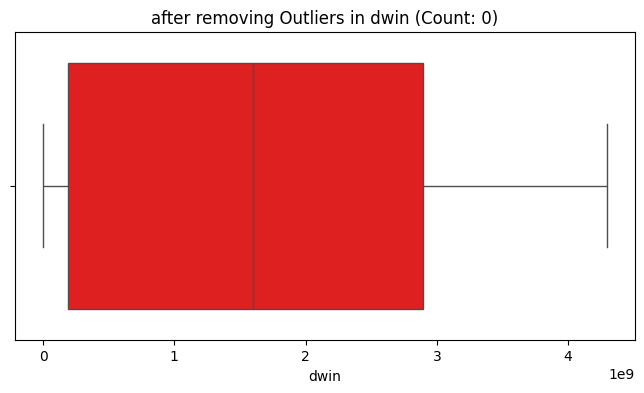

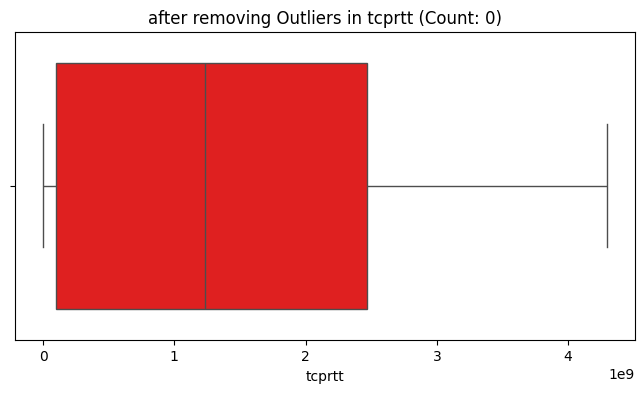

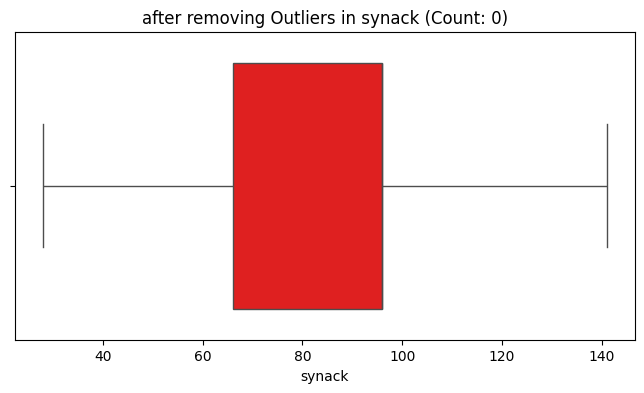

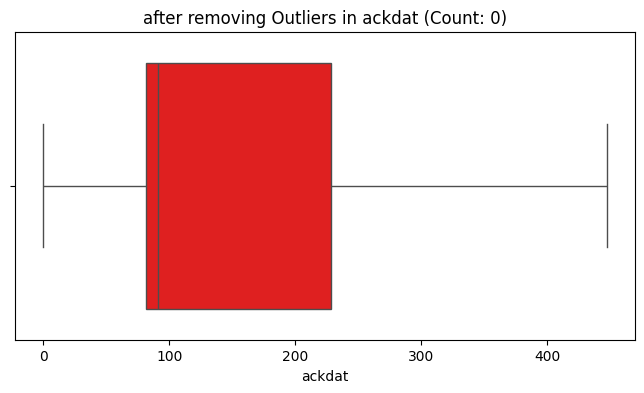

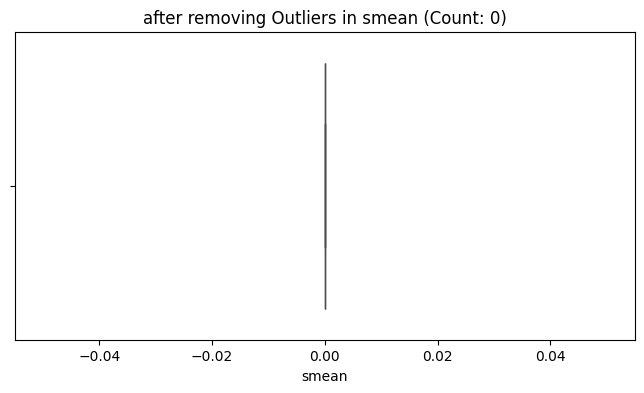

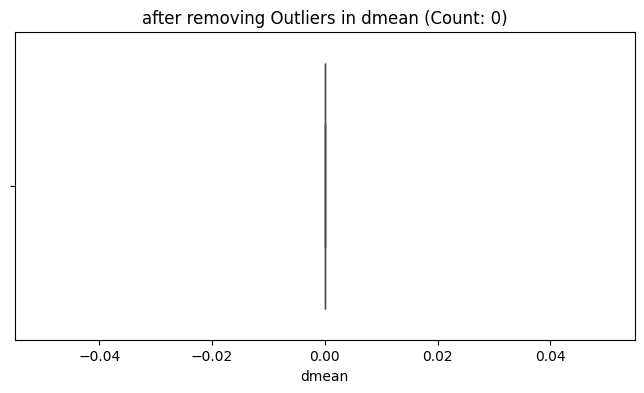

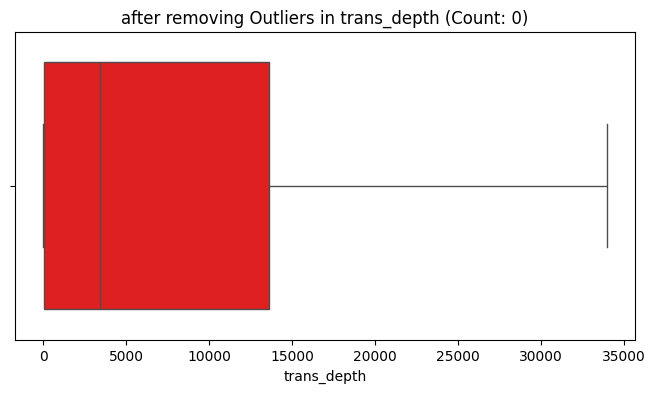

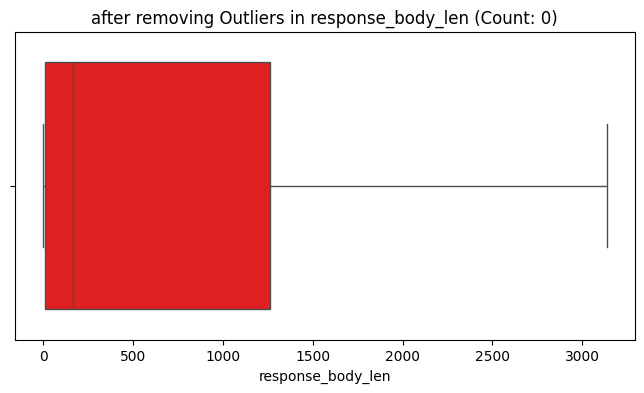

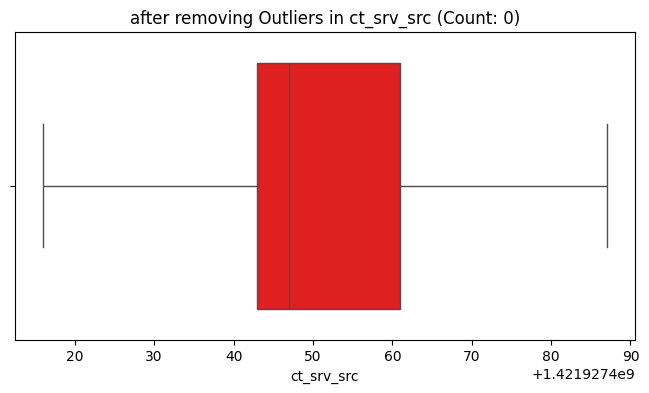

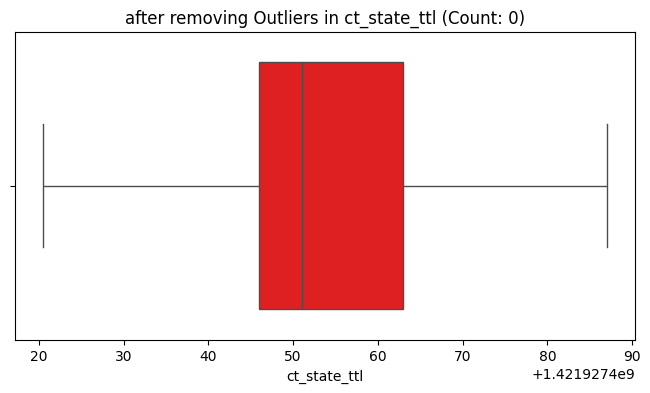

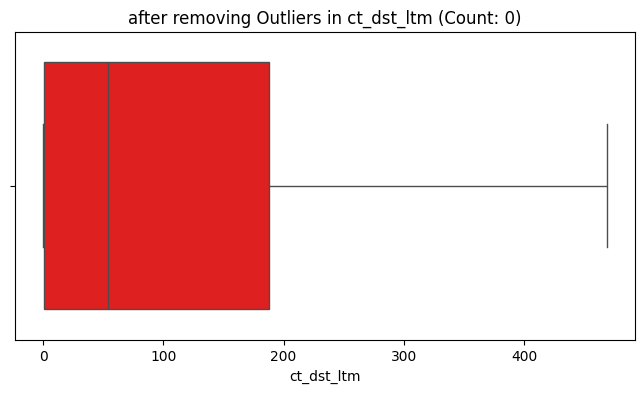

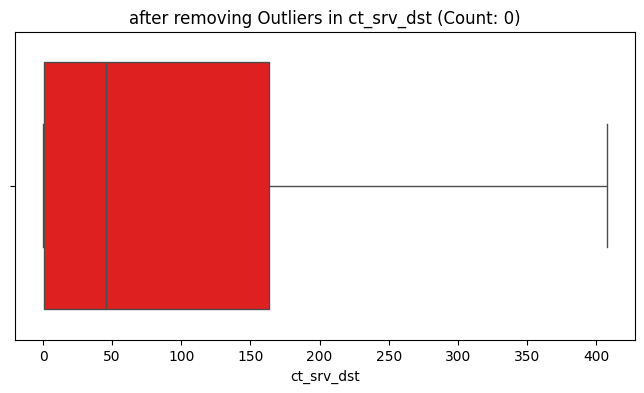

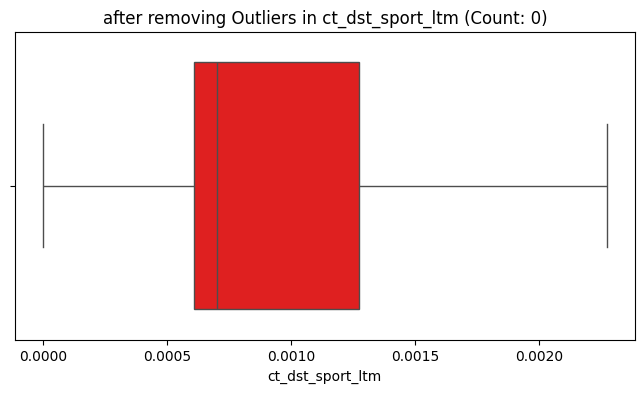

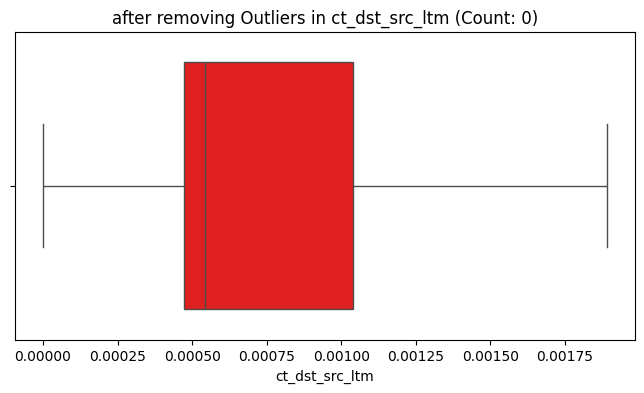

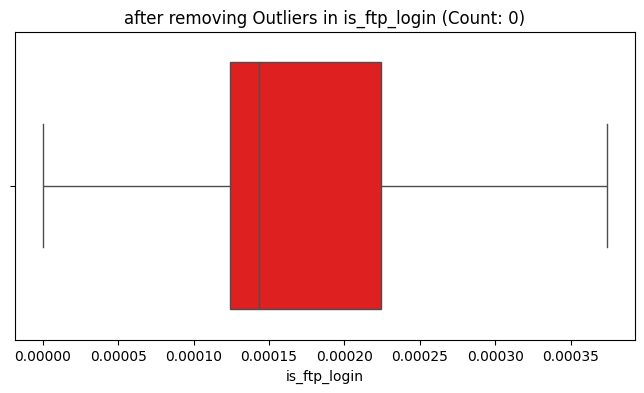

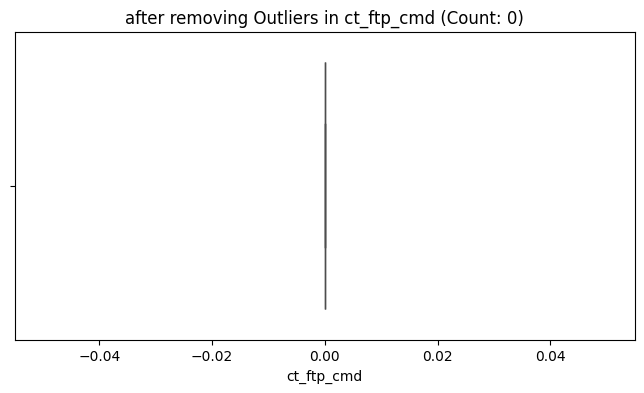

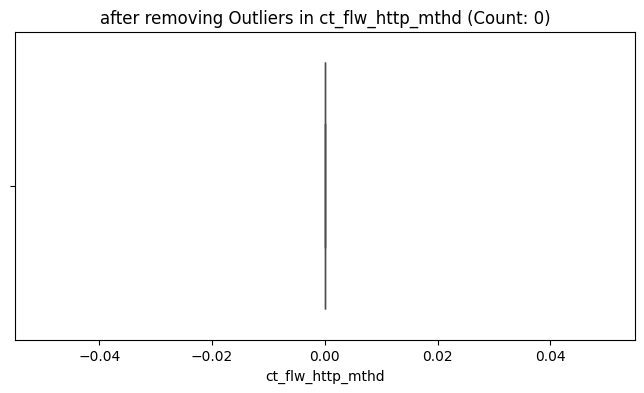

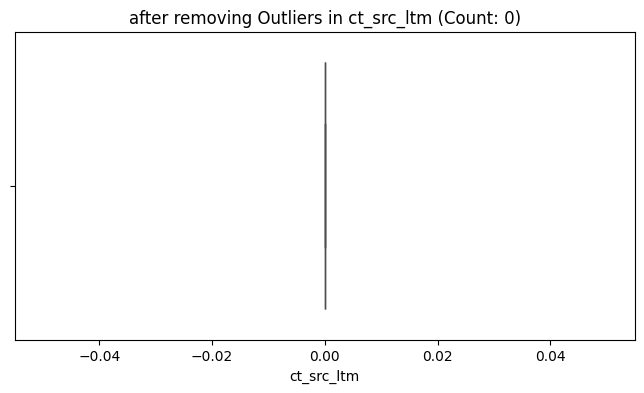

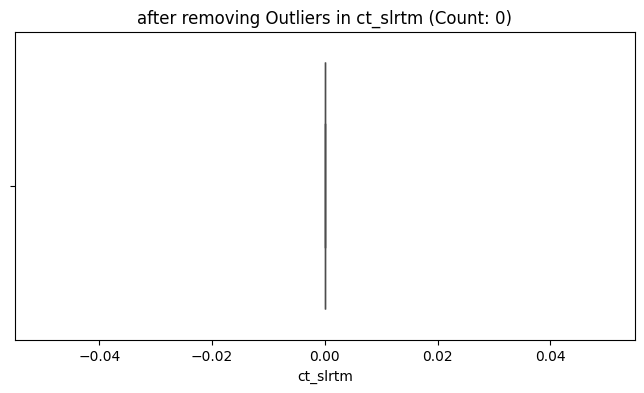

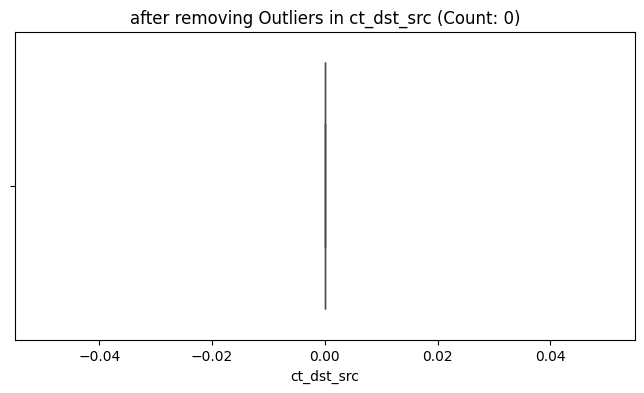

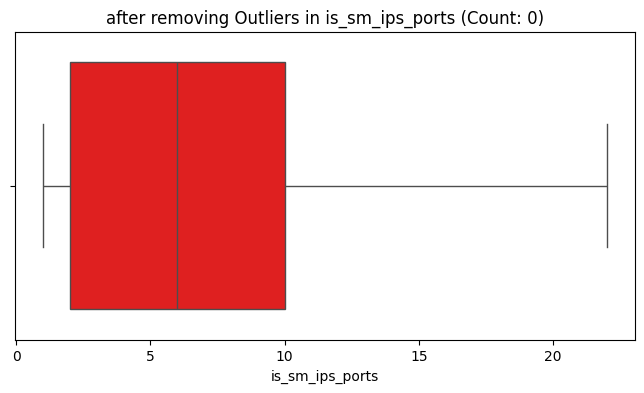

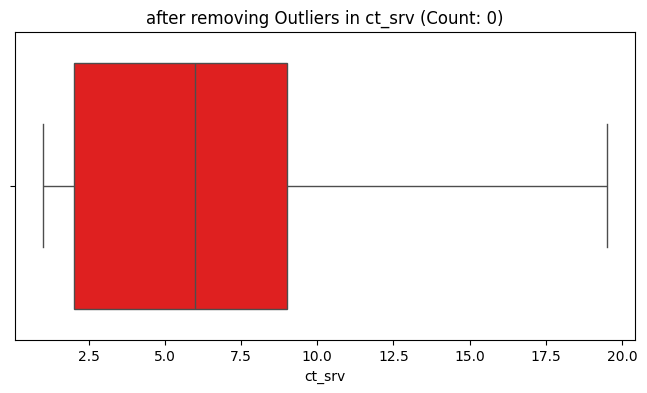

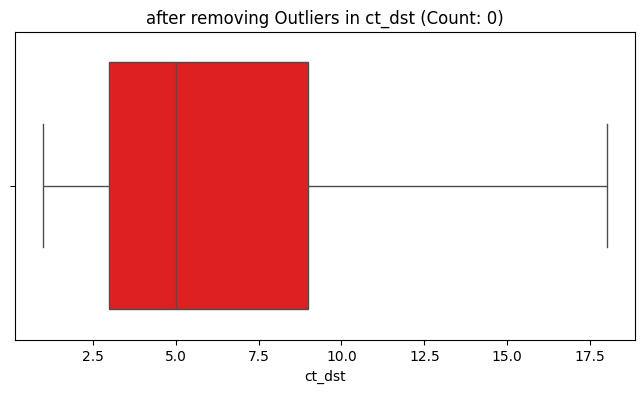

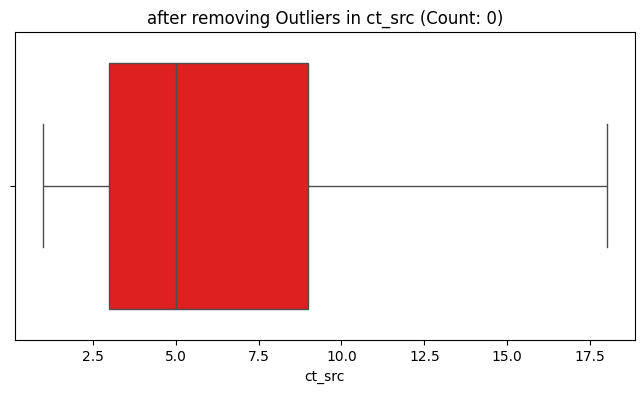

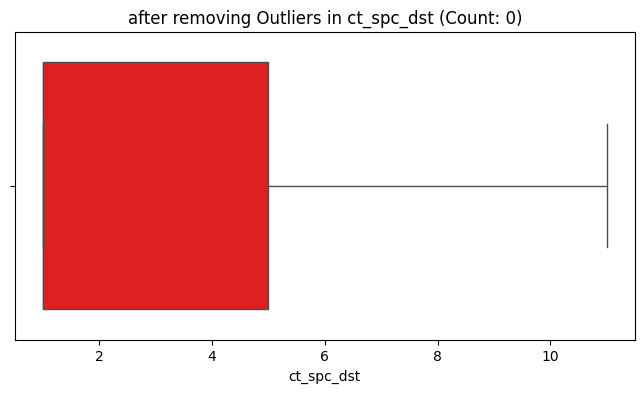

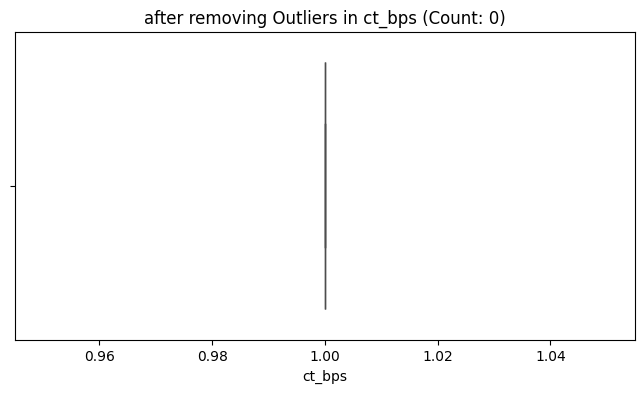

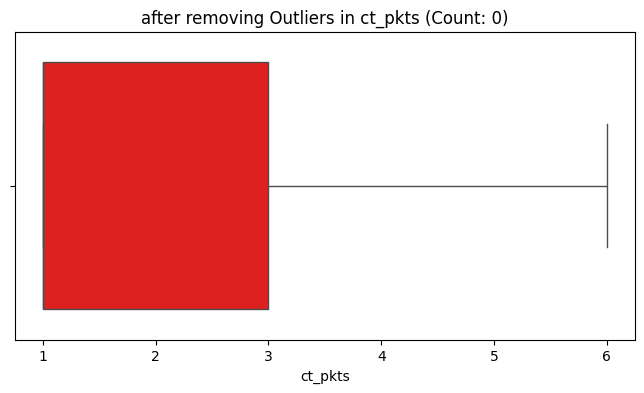

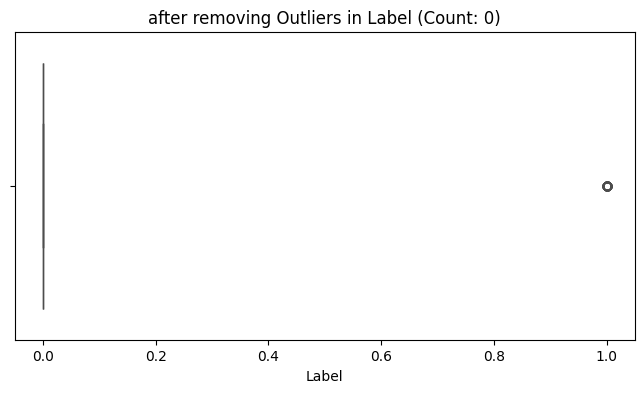

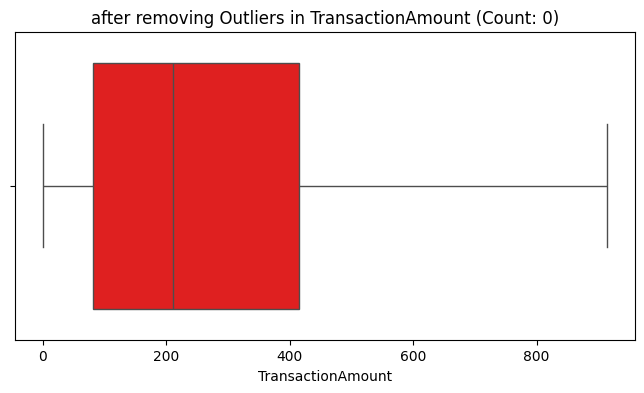

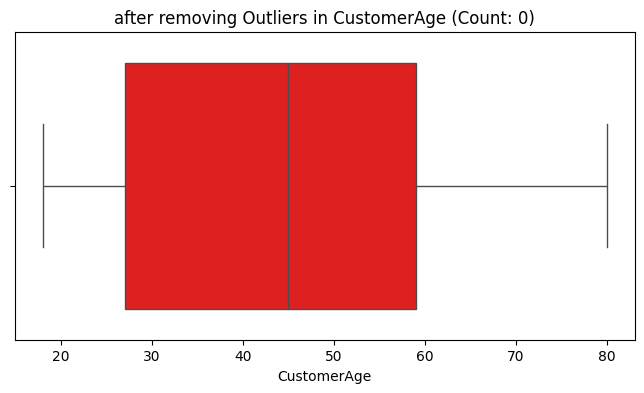

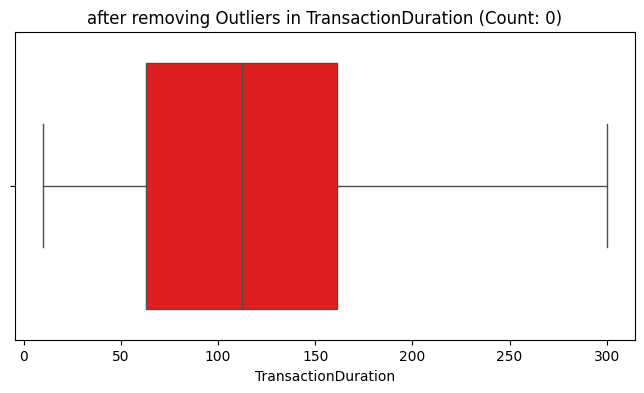

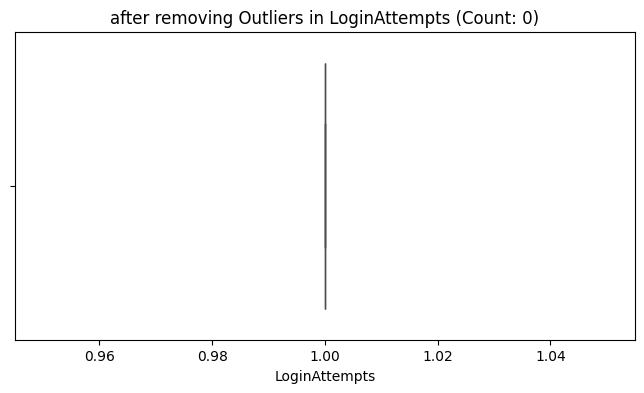

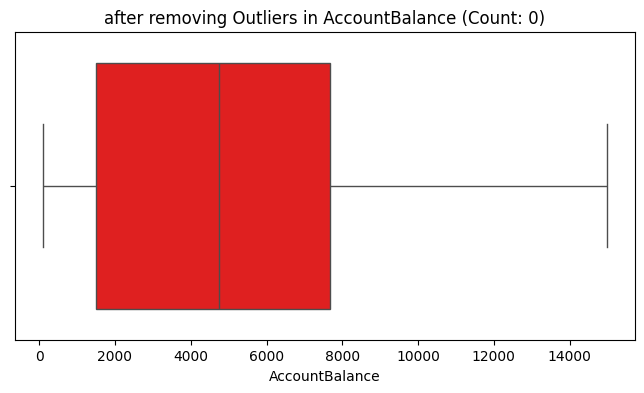

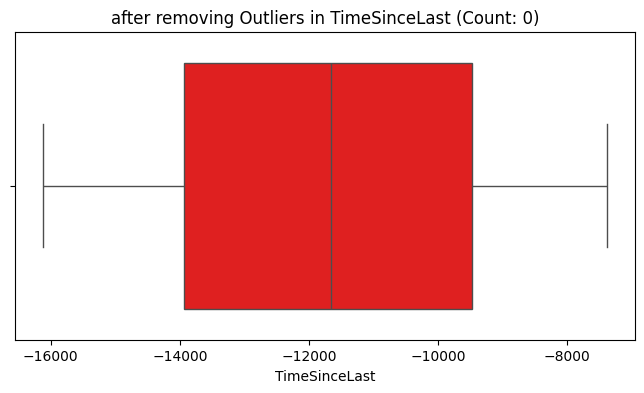

In [ ]:
# Outlier Detection

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=merged_df2[col],color="red")
    plt.title(f"after removing Outliers in {col} (Count: {len(outliers)})")
    plt.show()



In [ ]:
merged_df2.head(5)

dur  proto        service state spkts dpkts    sbytes  dbytes  \
index                                                                         
0      59.166.0.0   1390  149.171.126.6    53   udp   CON  0.001055     132   
1      59.166.0.0  33661  149.171.126.9  1024   udp   CON  0.036133     528   
2      59.166.0.6   1464  149.171.126.7    53   udp   CON  0.001119     146   
3      59.166.0.5   3593  149.171.126.5    53   udp   CON  0.001209     132   
4      59.166.0.3  49664  149.171.126.0    53   udp   CON  0.001169     146   

       rate  sttl  ...  TransactionType   Location      IP Address Channel  \
index              ...                                                       
0       164    31  ...            Debit  San Diego  162.198.218.92     ATM   
1       304    31  ...            Debit    Houston     13.149.61.4     ATM   
2       178    31  ...            Debit       Mesa  215.97.143.157  Online   
3       164    31  ...            Debit    Raleigh  200.13.225.150  Online   
4       178    31  ...           Credit    Atlanta    65.164.3.100  Online   

       CustomerAge  CustomerOccupation  TransactionDuration  LoginAttempts  \
index                                                                        
0               70              Doctor                   81              1   
1               68              Doctor                  141              1   
2               19             Student                   56              1   
3               26             Student                   25              1   
4               26             Student                  198              1   

       AccountBalance  TimeSinceLast  
index                                 
0             5112.21  -13743.648333  
1            13758.91  -11895.421111  
2             1122.35  -11581.848889  
3             8569.06  -13167.615278  
4             7429.40   -9230.254167  

[5 rows x 59 columns]

In [ ]:
merged_df2.describe()

proto       sbytes       dbytes          rate    sttl    dttl  \
count   2512.000000  2512.000000  2512.000000   2512.000000  2512.0  2512.0   
mean   32190.344347     2.440096  1819.044586   5617.476115    31.0    29.0   
std    19136.513780     3.135942  1461.483692   7559.579587     0.0     0.0   
min        0.000000     0.000000    46.000000      0.000000    31.0    29.0   
25%    15611.750000     0.033137   568.000000    824.000000    31.0    29.0   
50%    31846.000000     0.963918  1540.000000   1644.000000    31.0    29.0   
75%    48983.250000     3.763024  2302.000000   8824.000000    31.0    29.0   
max    65534.000000     9.357854  4903.000000  20824.000000    31.0    29.0   

             sload        dload         dloss        sinpkt  ...   ct_spc_dst  \
count  2512.000000  2512.000000  2.512000e+03  2.512000e+03  ...  2512.000000   
mean      3.975717     5.859475  2.067232e+05  2.592630e+05  ...     3.236465   
std       3.169920     5.781616  3.343707e+05  3.923547e+05  ...     3.284683   
min       0.000000     0.000000  0.000000e+00  0.000000e+00  ...     1.000000   
25%       1.000000     2.000000  3.694056e+03  4.913987e+03  ...     1.000000   
50%       4.000000     4.000000  1.390930e+04  2.879812e+04  ...     1.000000   
75%       5.000000     8.000000  4.685981e+05  5.232792e+05  ...     5.000000   
max      11.000000    17.000000  1.165954e+06  1.300827e+06  ...    11.000000   

       ct_bps      ct_pkts        Label  TransactionAmount  CustomerAge  \
count  2512.0  2512.000000  2512.000000        2512.000000  2512.000000   
mean      1.0     2.317675     0.031449         284.847250    44.673965   
std       0.0     1.725312     0.174563         252.067285    17.792198   
min       1.0     1.000000     0.000000           0.260000    18.000000   
25%       1.0     1.000000     0.000000          81.885000    27.000000   
50%       1.0     1.000000     0.000000         211.140000    45.000000   
75%       1.0     3.000000     0.000000         414.527500    59.000000   
max       1.0     6.000000     1.000000         913.491250    80.000000   

       TransactionDuration  LoginAttempts  AccountBalance  TimeSinceLast  
count          2512.000000         2512.0     2512.000000    2512.000000  
mean            119.643312            1.0     5114.302966  -11699.619831  
std              69.963757            0.0     3900.942499    2553.112410  
min              10.000000            1.0      101.250000  -16120.185556  
25%              63.000000            1.0     1504.370000  -13935.794653  
50%             112.500000            1.0     4735.510000  -11654.350833  
75%             161.000000            1.0     7678.820000   -9469.433750  
max             300.000000            1.0    14977.990000   -7381.747500  

[8 rows x 48 columns]

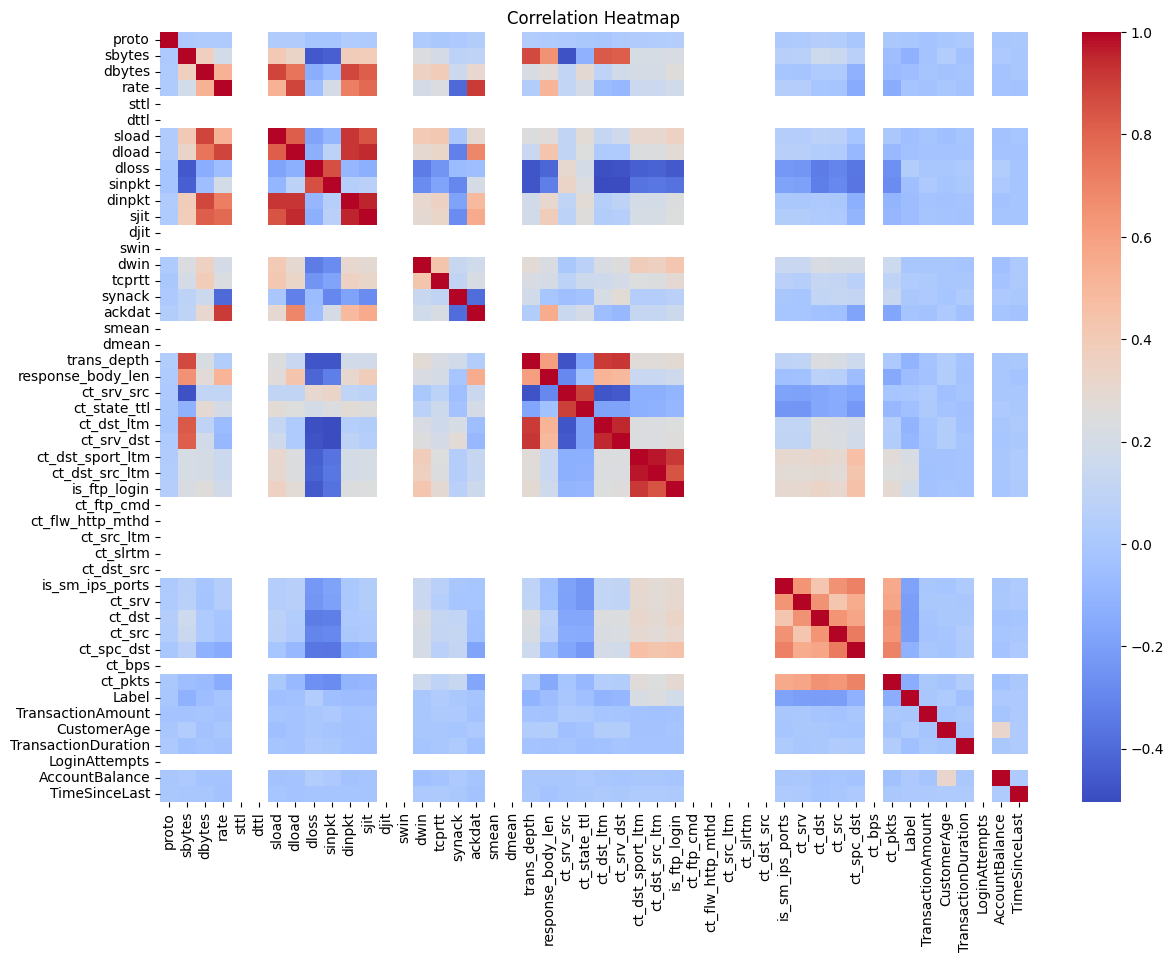

In [ ]:
# Correlation Heatmap (Numerical)

if len(num_cols) >= 2:
    plt.figure(figsize=(14, 10))
    sns.heatmap(merged_df2[num_cols].corr(), annot=False, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()


In [ ]:
# Pairplot

if len(num_cols) >= 2:
    sns.pairplot(merged_df2[num_cols])
    plt.show()


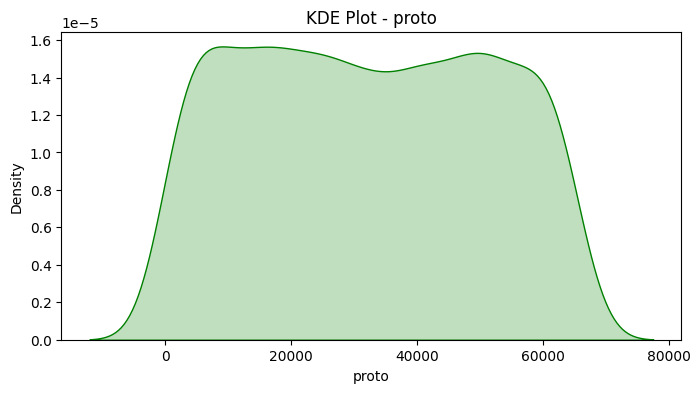

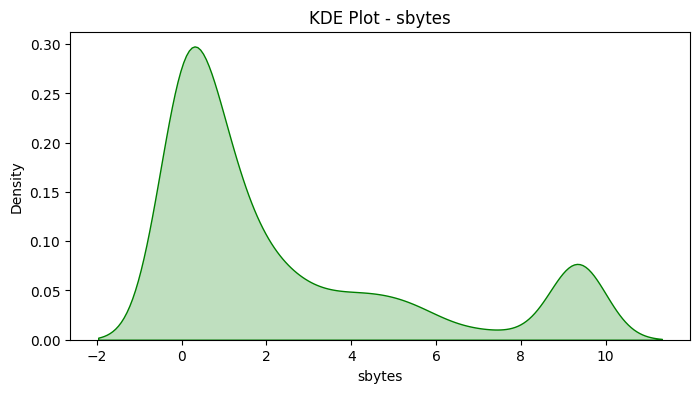

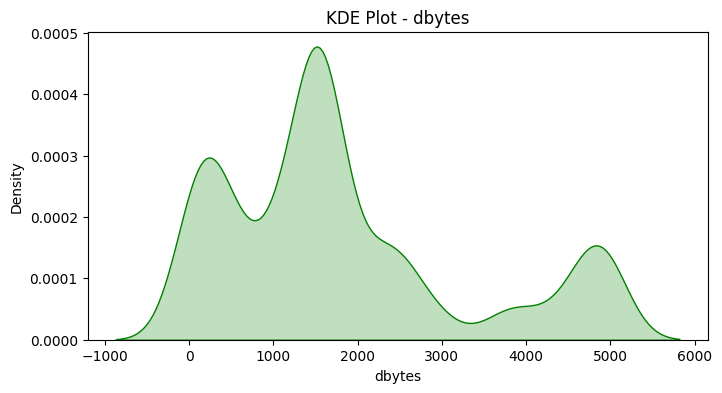

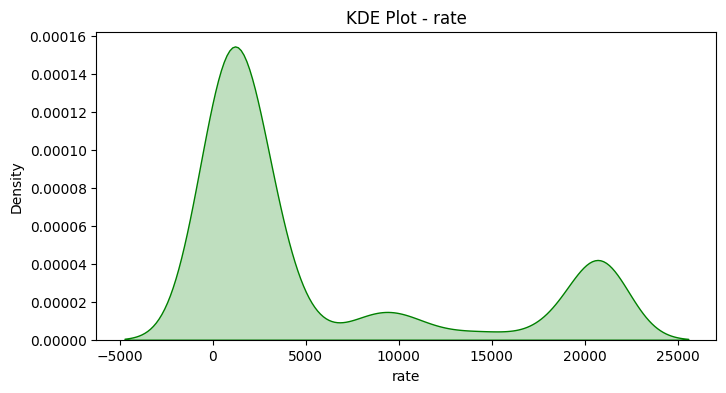

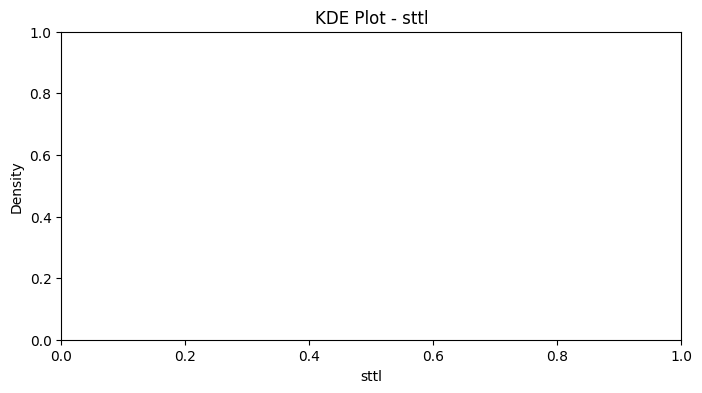

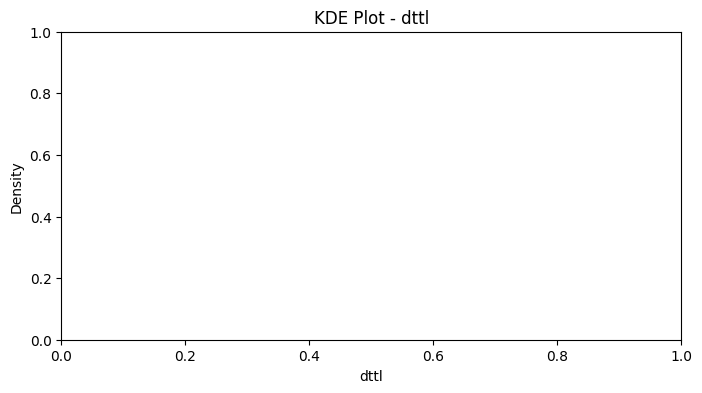

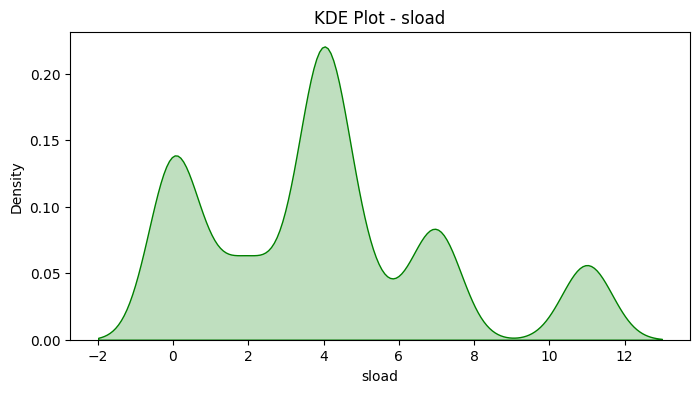

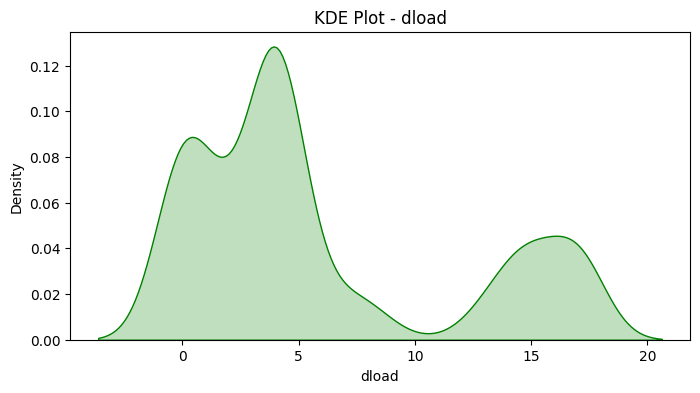

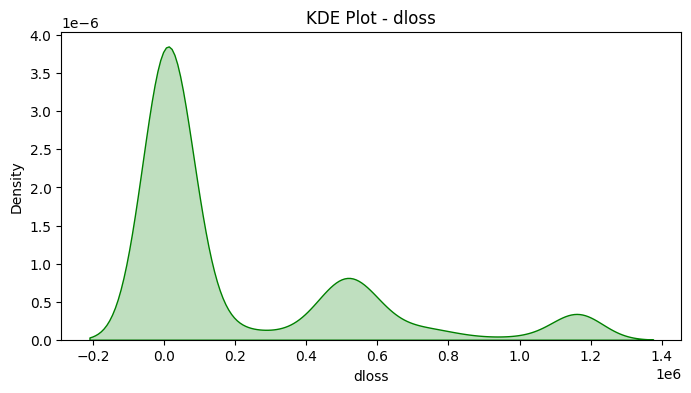

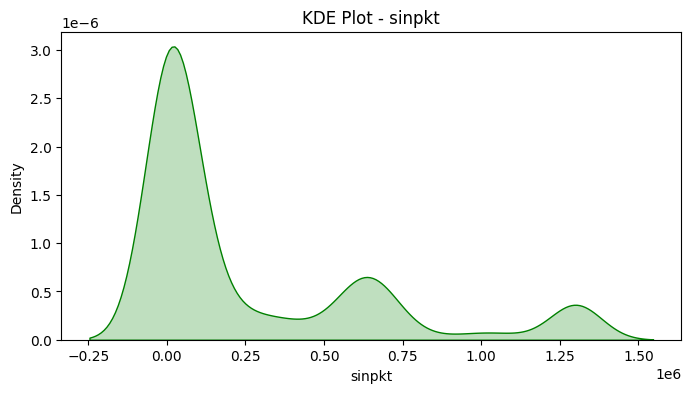

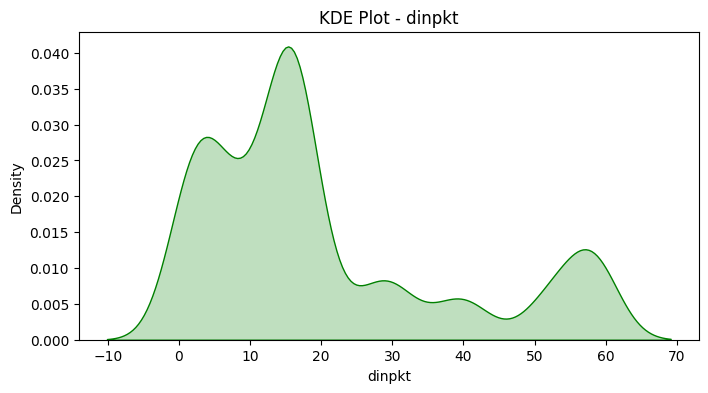

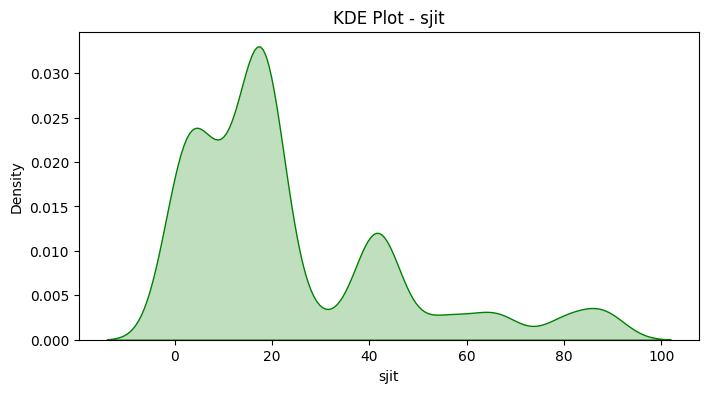

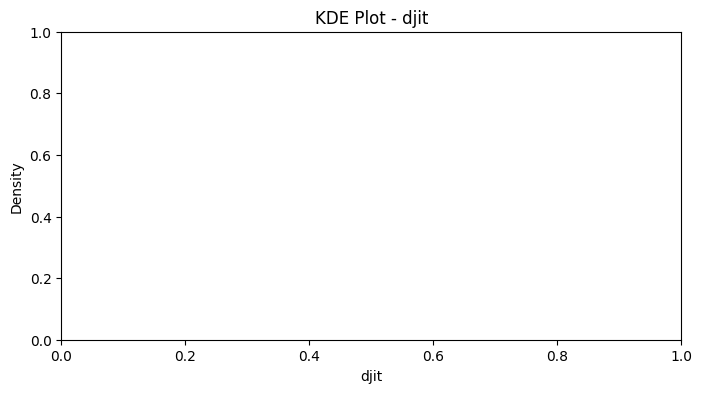

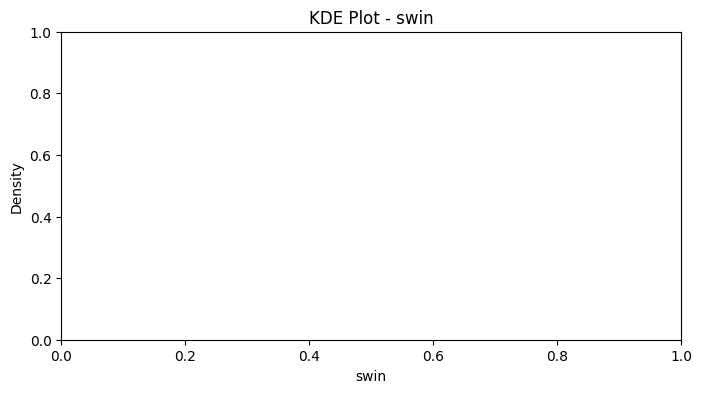

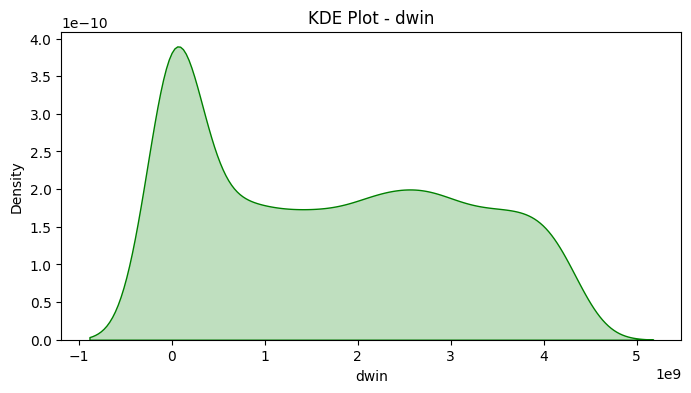

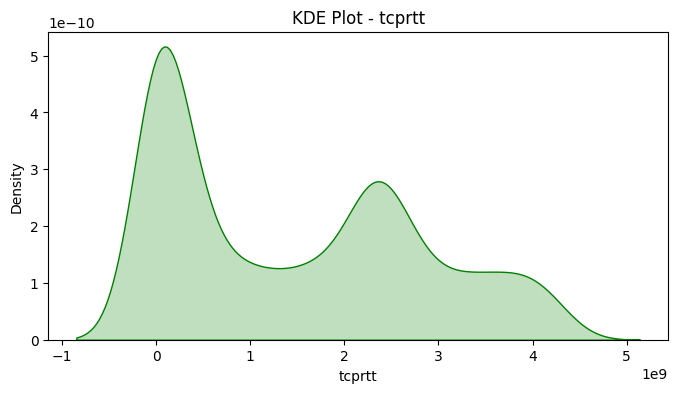

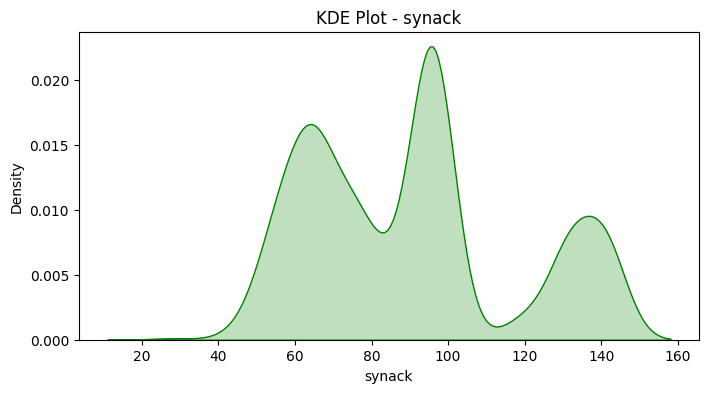

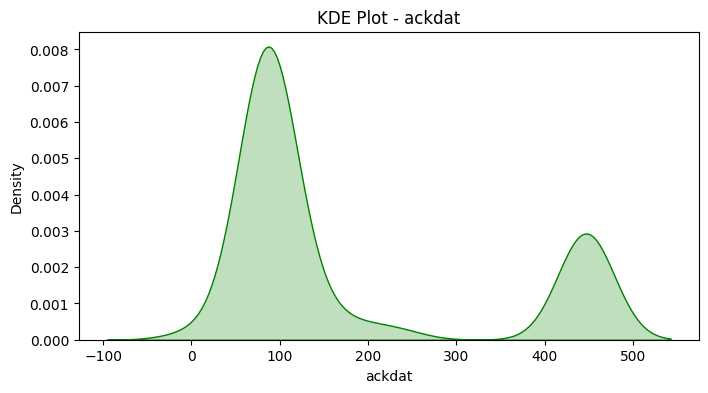

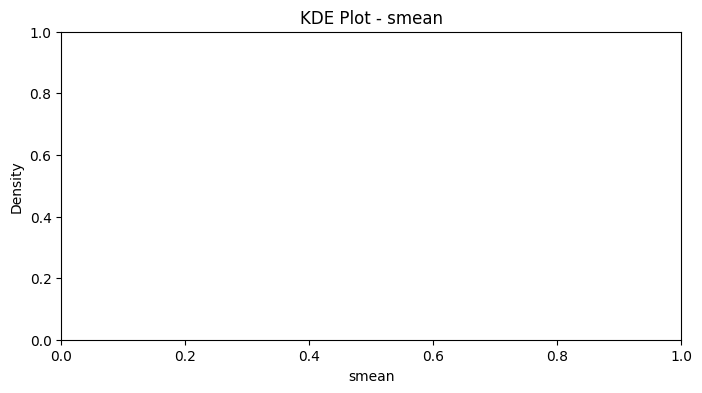

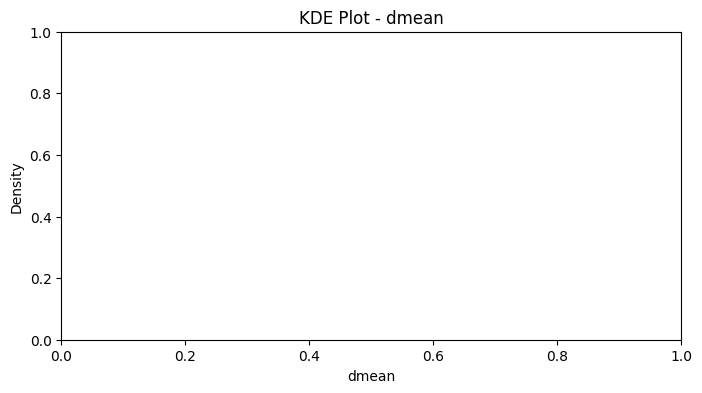

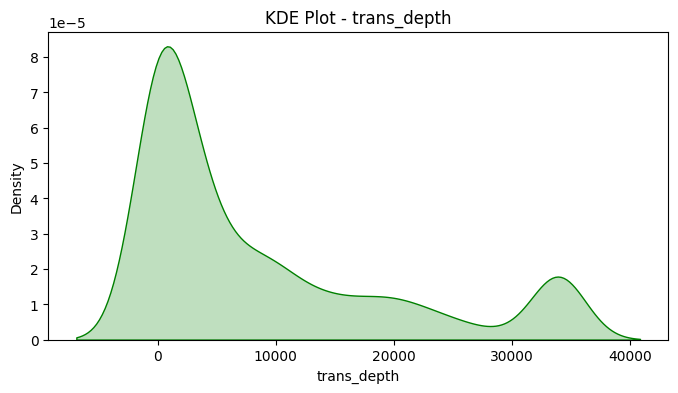

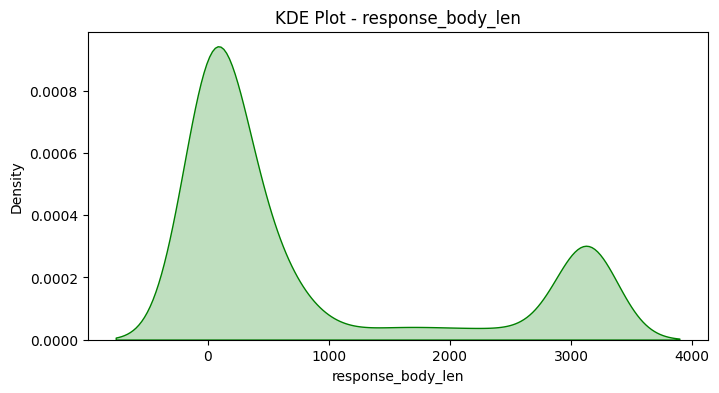

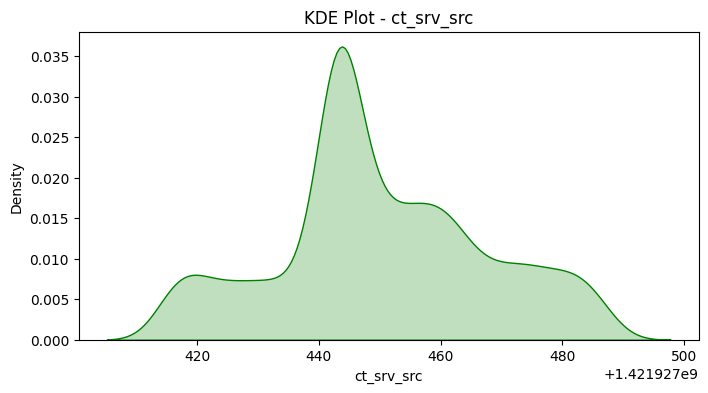

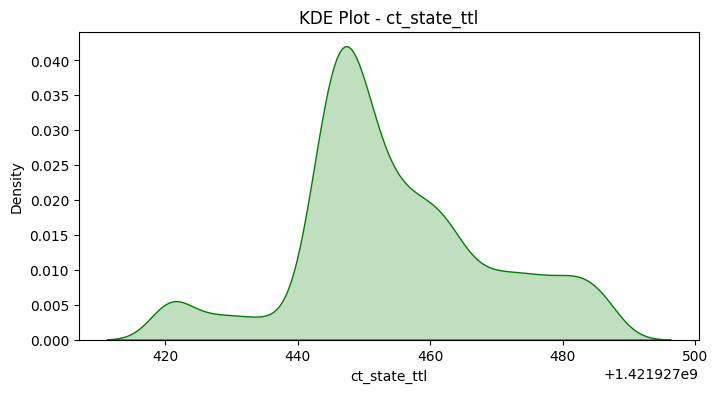

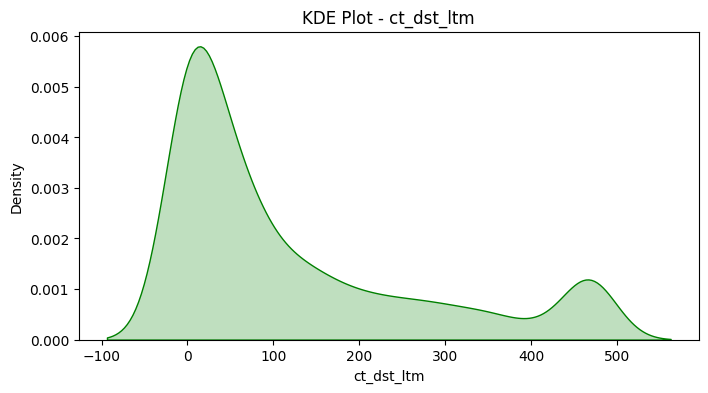

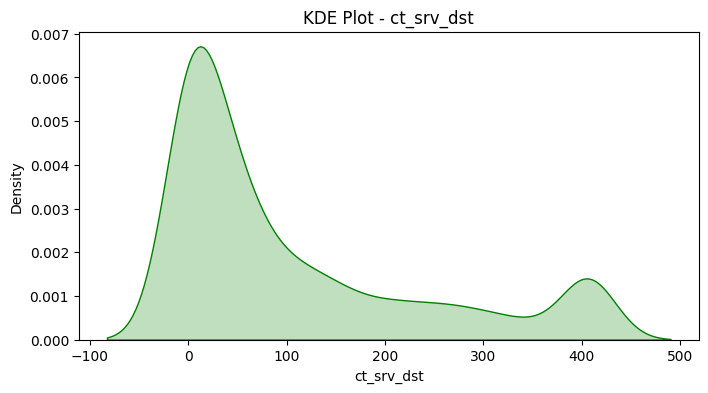

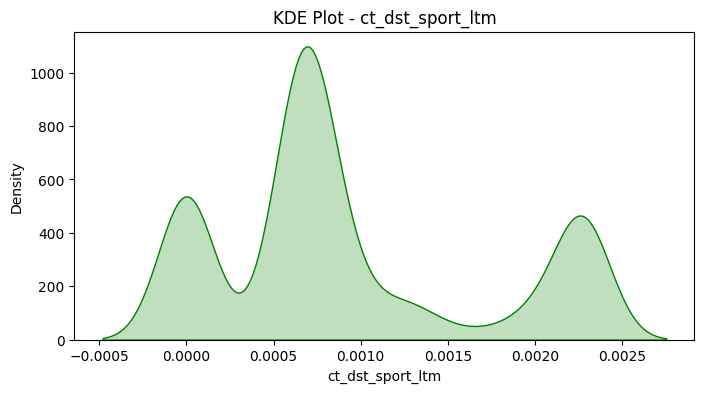

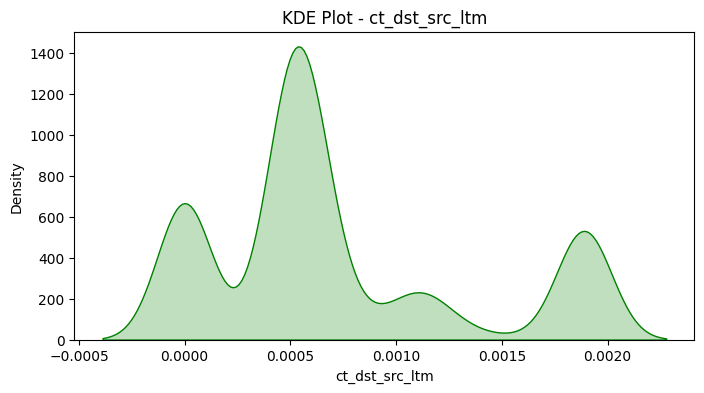

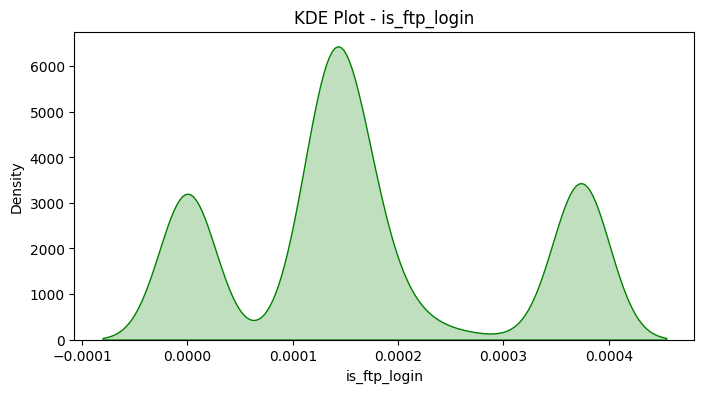

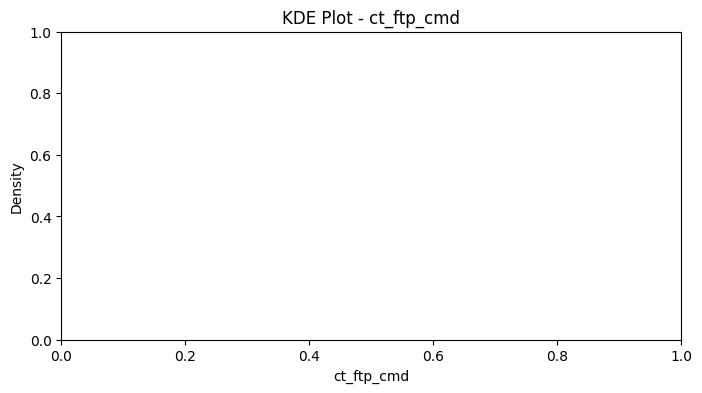

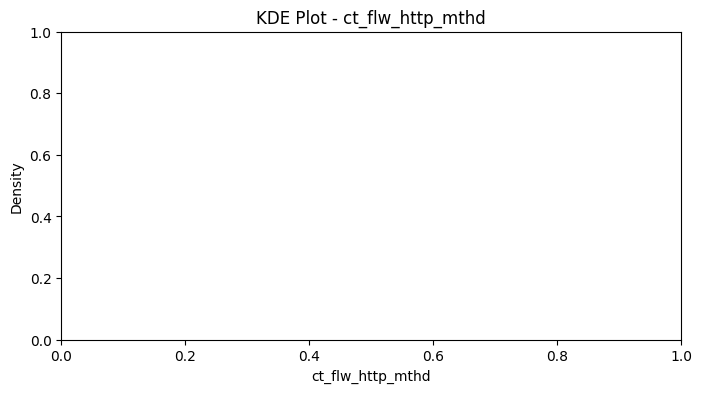

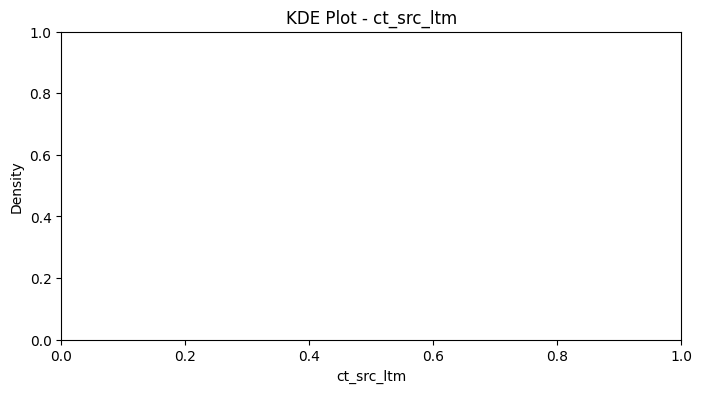

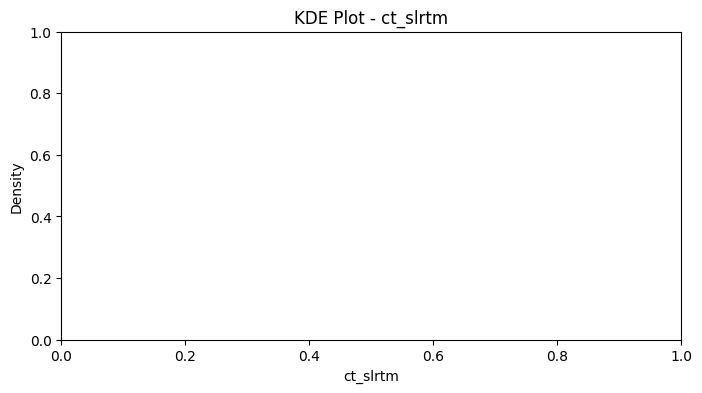

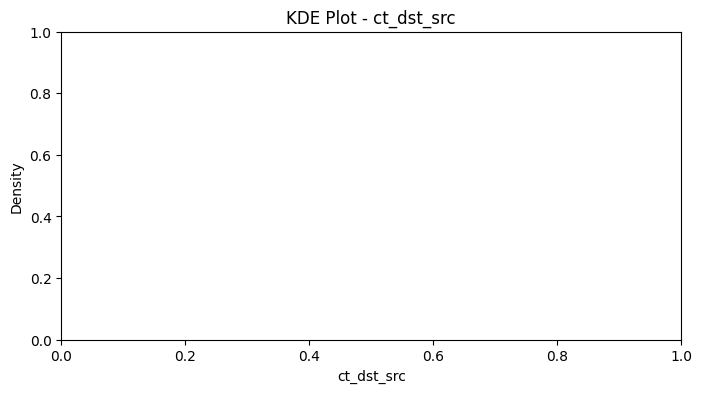

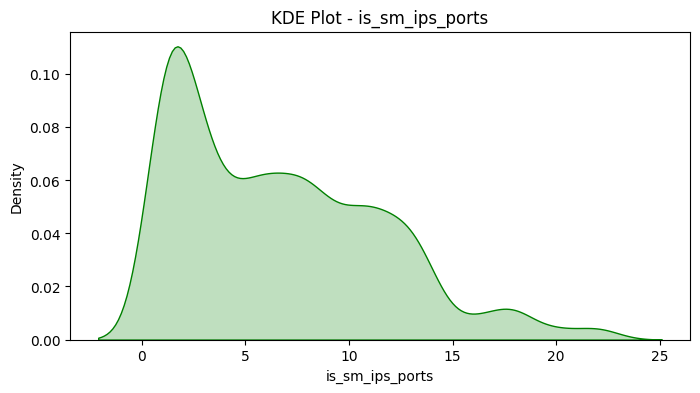

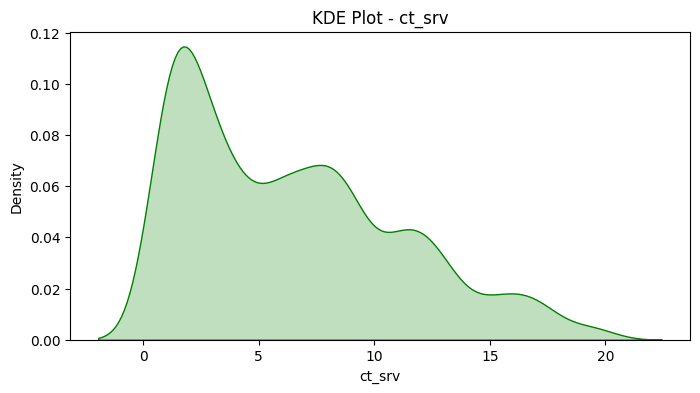

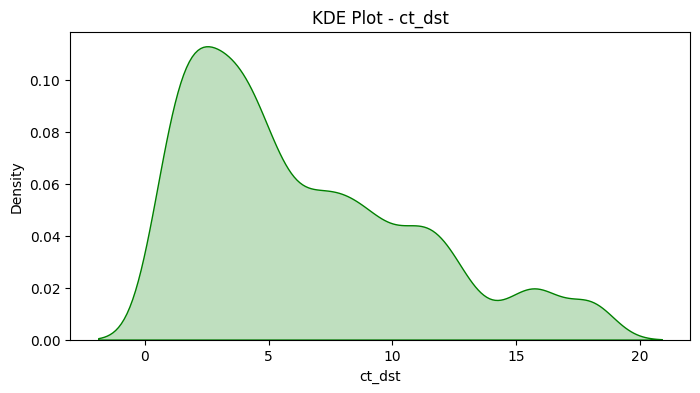

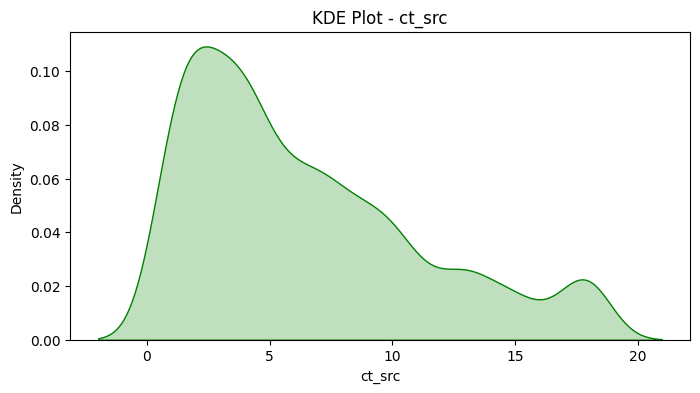

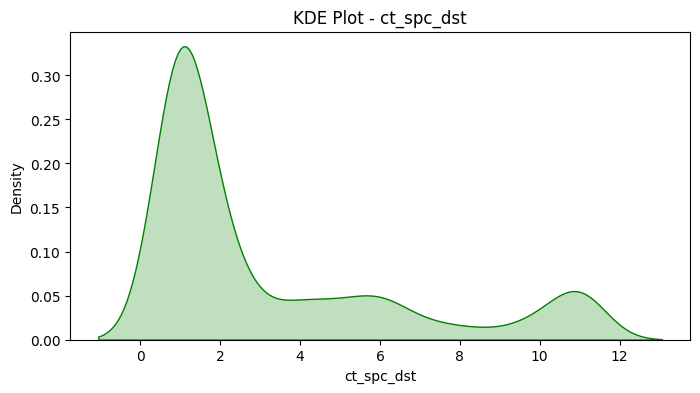

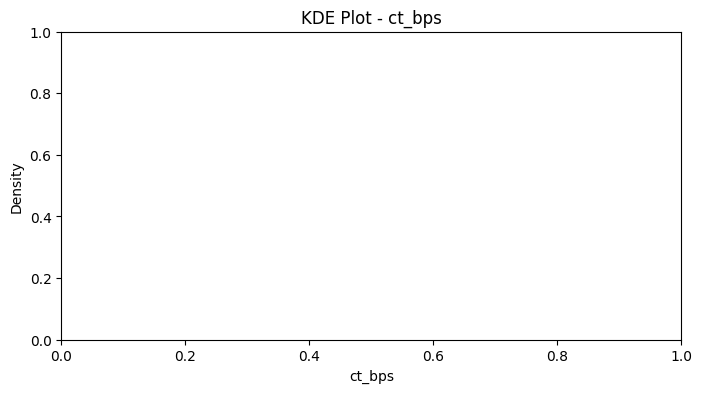

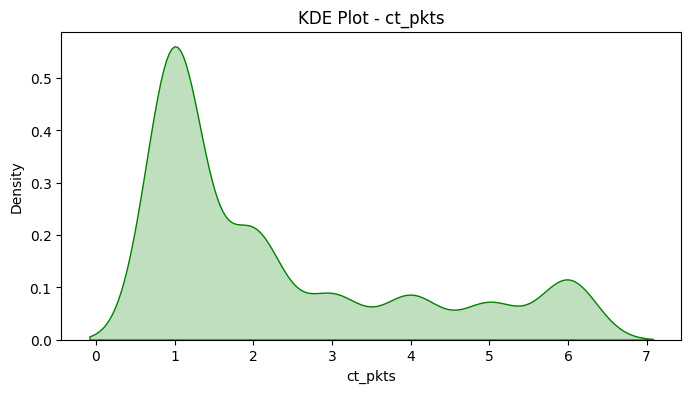

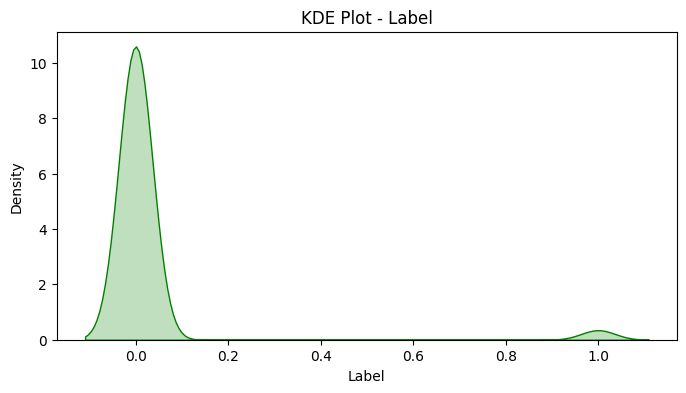

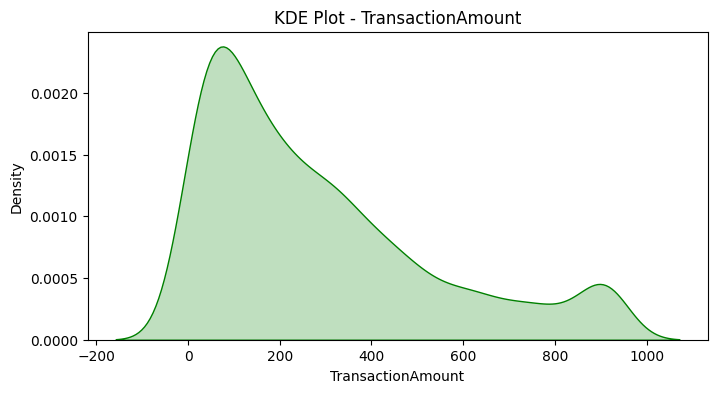

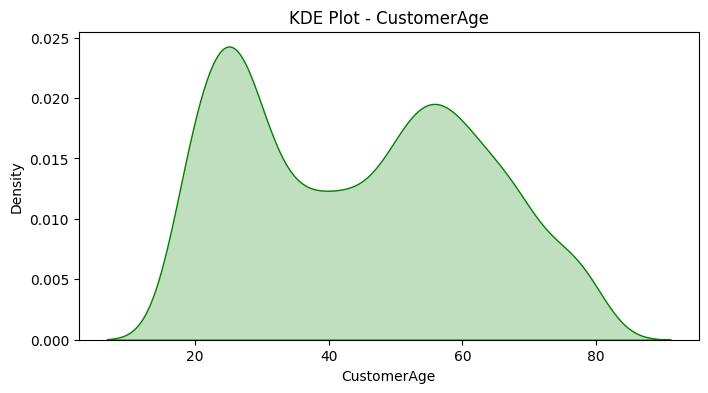

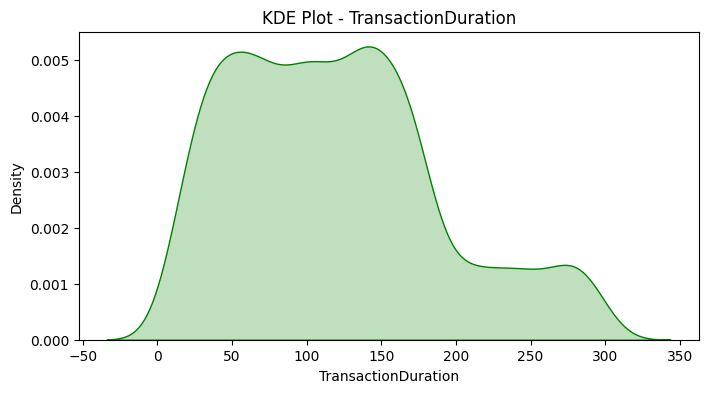

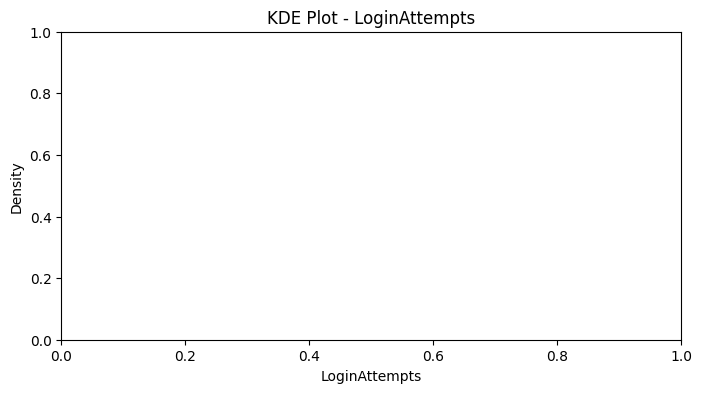

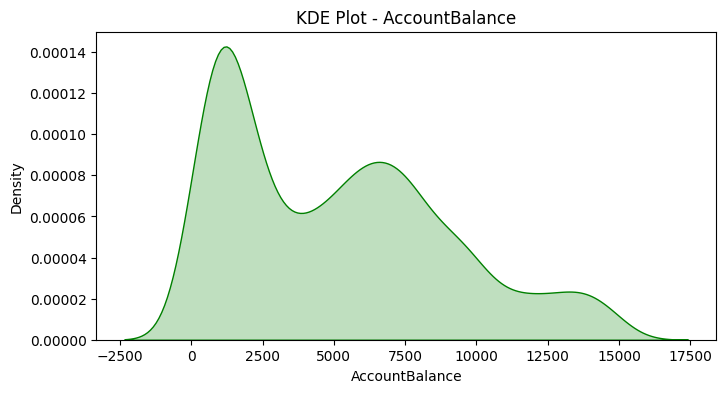

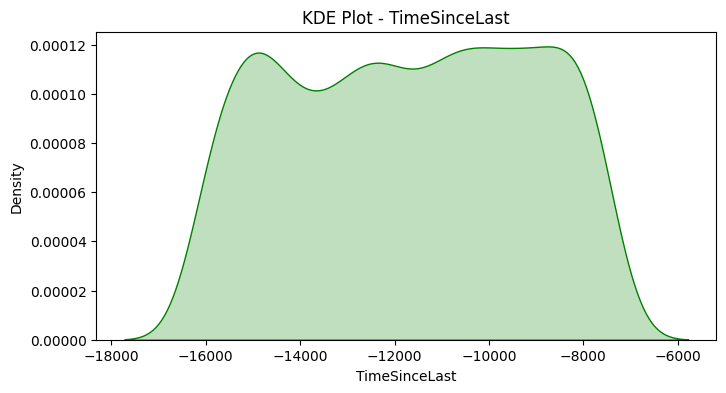

In [ ]:
# KDE Plots (Numerical)

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(merged_df2[col], fill=True,color="green")
    plt.title(f"KDE Plot - {col}")
    plt.show()


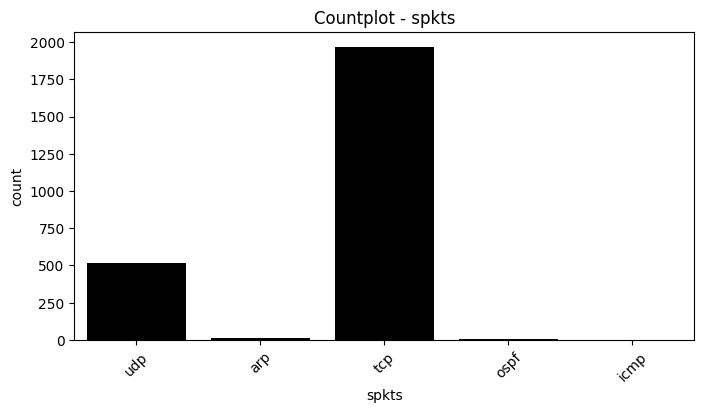

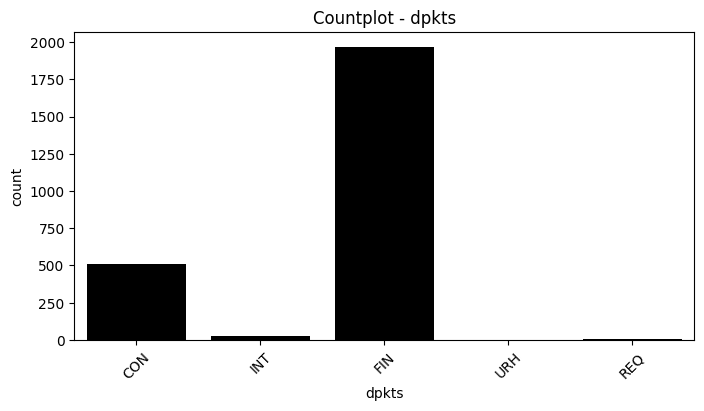

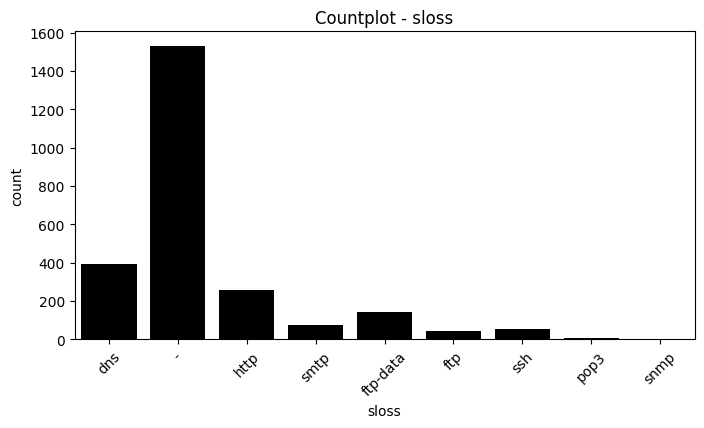

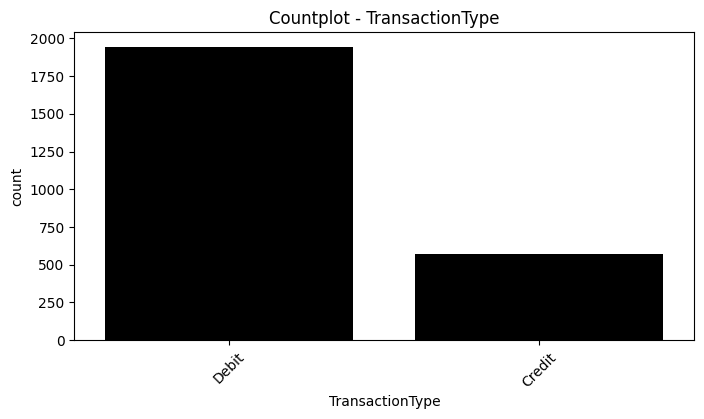

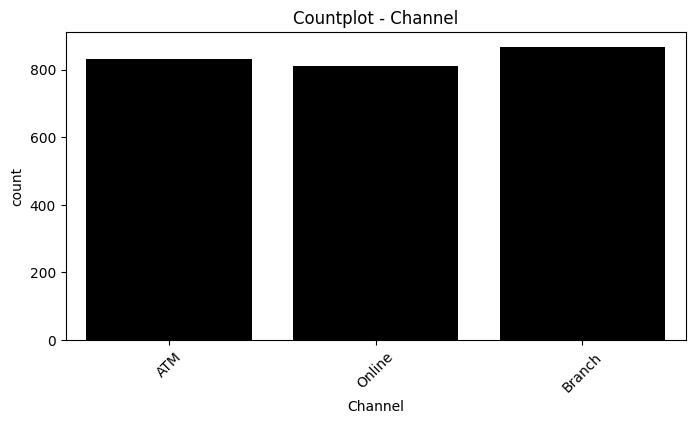

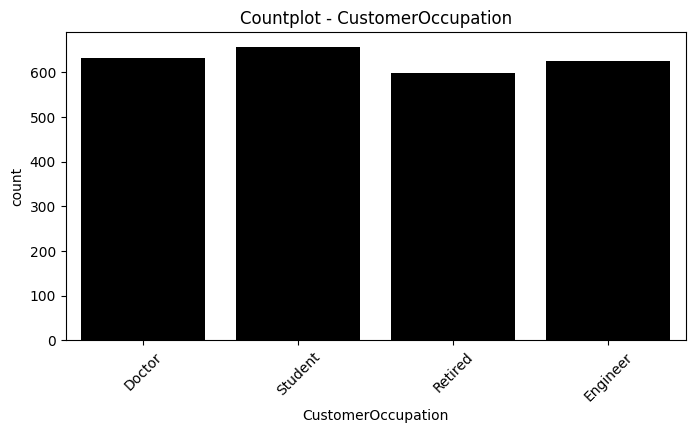

In [ ]:
# 6. Categorical Column Visualizations

for col in cat_cols:
    if merged_df2[col].nunique() <= 15:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=merged_df2[col],color="black")
        plt.title(f"Countplot - {col}")
        plt.xticks(rotation=45)
        plt.show()



In [ ]:
# Features (X) and Target (Y)

Y = merged_df2['Label']
X = merged_df2.drop(columns=['Label'])

print(f"Features (X) shape: {X.shape}")
print(f"Target (Y) shape: {Y.shape}")
print(f"Target (Y) distribution:\n{Y.value_counts()}")

Features (X) shape: (2512, 58)
Target (Y) shape: (2512,)
Target (Y) distribution:
Label
0    2433
1      79
Name: count, dtype: int64
